<a href="https://colab.research.google.com/github/yousrabougara/WalmartSalesForecasting/blob/main/LightGBM_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('Walmart.csv')

In [ ]:
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.shape

(6435, 8)

In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [4]:
df.fillna(0, inplace=True)

In [5]:
def get_season(month):
    '''this function is to get season according to month column'''
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [6]:
import numpy as np
import pandas as pd

In [7]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = df['Month'].apply(get_season)

In [8]:
df['Store'] = df['Store'].astype('object')

In [9]:
pip install lightgbm

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


In [11]:
num_vars = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']

# scaling numerical variables
sc = StandardScaler()
df[num_vars] = sc.fit_transform(df[num_vars])

# encoding categorical features
encoder = BinaryEncoder(cols=['Store','Season'])
df = encoder.fit_transform(df)

In [12]:
features = df.columns.drop(['Weekly_Sales','Date','Year'])
target = 'Weekly_Sales'

X = df[features]
y = df[target]

X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=42 ,  test_size=0.2)

In [13]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score


# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the LightGBM model using the early_stopping callback
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)],  # Pass verbose_eval to log_evaluation callback
)

# Predict on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
# Evaluate the model
if params['objective'] == 'regression':
    # Calculate RMSE without the 'squared' argument for older scikit-learn versions
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")
else:  # For classification
    y_pred_binary = (y_pred > 0.5).astype(int) if params['objective'] == 'binary' else y_pred.argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred_binary)
    print(f"Accuracy: {accuracy}")

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.194004	valid_1's rmse: 0.222503
[200]	training's rmse: 0.15189	valid_1's rmse: 0.200784
[300]	training's rmse: 0.132816	valid_1's rmse: 0.195573
[400]	training's rmse: 0.120153	valid_1's rmse: 0.192256
[500]	training's rmse: 0.110815	valid_1's rmse: 0.190107
[600]	training's rmse: 0.103054	valid_1's rmse: 0.189216
Early stopping, best iteration is:
[577]	training's rmse: 0.104603	valid_1's rmse: 0.1891
RMSE: 0.18910035949236356


In [14]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the LightGBM model using the early_stopping callback
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

# Predict on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
# R2 Score
r2 = r2_score(y_test, y_pred)

# Print results
print("Final Test R2 Score:", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# Training and test set accuracy
train_score = model.predict(X_train, num_iteration=model.best_iteration)
train_r2 = r2_score(y_train, train_score)
print("Training set R2 Score:", train_r2)

# Test set accuracy (percentage)
test_r2 = r2
print("Test set R2 Score:", test_r2)


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.194004	valid_1's rmse: 0.222503
[200]	training's rmse: 0.15189	valid_1's rmse: 0.200784
[300]	training's rmse: 0.132816	valid_1's rmse: 0.195573
[400]	training's rmse: 0.120153	valid_1's rmse: 0.192256
[500]	training's rmse: 0.110815	valid_1's rmse: 0.190107
[600]	training's rmse: 0.103054	valid_1's rmse: 0.189216
Early stopping, best iteration is:
[577]	training's rmse: 0.104603	valid_1's rmse: 0.1891
Final Test R2 Score: 0.96465112747043
Mean Squared Error (MSE): 0.035758945960141134
Root Mean Squared Error (RMSE): 0.18910035949236356
Mean Absolute Error (MAE): 0.1110480002021541
Training set R2 Score: 0.9890256661912437
Test set R2 Score: 0.96465112747043


In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.9 MB/s eta 0:00:00


In [16]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'verbose': -1
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    # Train the model using callbacks for early stopping
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, test_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),  # Use callback for early stopping
            lgb.log_evaluation(100)  # Log evaluation every 100 iterations
        ]
    )

    # Predict on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Calculate and return the R² score (Optuna maximizes this score)
    return r2_score(y_test, y_pred)

In [17]:

# Create an Optuna study to maximize R²
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

results = []
for trial in study.trials:
    trial_result = trial.params.copy()
    trial_result['r2_score'] = trial.value
    trial_result['trial_number'] = trial.number
    results.append(trial_result)

# 📌 Convertir en DataFrame
results_df = pd.DataFrame(results)

# Display the best hyperparameters found by Optuna
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

# Train the final model with the best parameters
final_model = lgb.train(
    {**best_params, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1},
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=1000,
    valid_sets=[lgb.Dataset(X_test, label=y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

# Predict on the test set
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)

# Evaluate the final model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Final Test R2 Score:", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)



[I 2025-05-30 09:03:01,296] A new study created in memory with name: no-name-4c11b2ae-055f-4676-a2c1-83ca12790b68


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.41219	valid_1's rmse: 0.423009
[200]	training's rmse: 0.311325	valid_1's rmse: 0.331514
[300]	training's rmse: 0.273063	valid_1's rmse: 0.300457
[400]	training's rmse: 0.254896	valid_1's rmse: 0.28464
[500]	training's rmse: 0.245521	valid_1's rmse: 0.278101
[600]	training's rmse: 0.240318	valid_1's rmse: 0.274381
[700]	training's rmse: 0.237061	valid_1's rmse: 0.272889
[800]	training's rmse: 0.232142	valid_1's rmse: 0.269572
[900]	training's rmse: 0.228955	valid_1's rmse: 0.266658
[1000]	training's rmse: 0.226654	valid_1's rmse: 0.266341
Did not meet early stopping. Best iteration is:
[977]	training's rmse: 0.227205	valid_1's rmse: 0.26623


[I 2025-05-30 09:03:03,676] Trial 0 finished with value: 0.9299345950660449 and parameters: {'learning_rate': 0.024596332032058445, 'num_leaves': 141, 'max_depth': 9, 'feature_fraction': 0.8940377319738309, 'bagging_fraction': 0.6293109693359298, 'bagging_freq': 8, 'min_data_in_leaf': 12, 'lambda_l1': 6.605553627647519, 'lambda_l2': 6.918333605131346}. Best is trial 0 with value: 0.9299345950660449.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.537478	valid_1's rmse: 0.547837
[200]	training's rmse: 0.393094	valid_1's rmse: 0.413527
[300]	training's rmse: 0.33178	valid_1's rmse: 0.359354
[400]	training's rmse: 0.295594	valid_1's rmse: 0.327834
[500]	training's rmse: 0.279112	valid_1's rmse: 0.31325
[600]	training's rmse: 0.271599	valid_1's rmse: 0.307156
[700]	training's rmse: 0.267035	valid_1's rmse: 0.303837
[800]	training's rmse: 0.263309	valid_1's rmse: 0.300964
[900]	training's rmse: 0.25611	valid_1's rmse: 0.295487
[1000]	training's rmse: 0.252742	valid_1's rmse: 0.292827
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.252742	valid_1's rmse: 0.292827


[I 2025-05-30 09:03:12,093] Trial 1 finished with value: 0.9152358248529859 and parameters: {'learning_rate': 0.016735035261021526, 'num_leaves': 101, 'max_depth': 12, 'feature_fraction': 0.7936192981442229, 'bagging_fraction': 0.7807314798367916, 'bagging_freq': 9, 'min_data_in_leaf': 11, 'lambda_l1': 8.446173826167541, 'lambda_l2': 9.55018158028153}. Best is trial 0 with value: 0.9299345950660449.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.863276	valid_1's rmse: 0.859561
[200]	training's rmse: 0.8184	valid_1's rmse: 0.810714
[300]	training's rmse: 0.789896	valid_1's rmse: 0.780886
[400]	training's rmse: 0.770471	valid_1's rmse: 0.761216
[500]	training's rmse: 0.751848	valid_1's rmse: 0.742859
[600]	training's rmse: 0.736243	valid_1's rmse: 0.727883
[700]	training's rmse: 0.721851	valid_1's rmse: 0.715042
[800]	training's rmse: 0.710766	valid_1's rmse: 0.704325
[900]	training's rmse: 0.699977	valid_1's rmse: 0.69495


[I 2025-05-30 09:03:14,903] Trial 2 finished with value: 0.5400944864698041 and parameters: {'learning_rate': 0.016557674769041058, 'num_leaves': 64, 'max_depth': 2, 'feature_fraction': 0.6346062510123035, 'bagging_fraction': 0.8188159054918778, 'bagging_freq': 10, 'min_data_in_leaf': 33, 'lambda_l1': 9.82957689226089, 'lambda_l2': 3.0917583408409968}. Best is trial 0 with value: 0.9299345950660449.


[1000]	training's rmse: 0.684876	valid_1's rmse: 0.682086
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.684876	valid_1's rmse: 0.682086
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.381352	valid_1's rmse: 0.389143
[200]	training's rmse: 0.312125	valid_1's rmse: 0.334888
[300]	training's rmse: 0.274412	valid_1's rmse: 0.306696
[400]	training's rmse: 0.247	valid_1's rmse: 0.283648
[500]	training's rmse: 0.233248	valid_1's rmse: 0.273329
[600]	training's rmse: 0.221387	valid_1's rmse: 0.266528
[700]	training's rmse: 0.212546	valid_1's rmse: 0.259821
[800]	training's rmse: 0.205917	valid_1's rmse: 0.254782
[900]	training's rmse: 0.20022	valid_1's rmse: 0.252346
[1000]	training's rmse: 0.195432	valid_1's rmse: 0.248183
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.195432	valid_1's rmse: 0.248183


[I 2025-05-30 09:03:24,429] Trial 3 finished with value: 0.9391116709156904 and parameters: {'learning_rate': 0.04689361438947251, 'num_leaves': 101, 'max_depth': 12, 'feature_fraction': 0.8093478176070329, 'bagging_fraction': 0.6068980473139188, 'bagging_freq': 7, 'min_data_in_leaf': 75, 'lambda_l1': 2.131842908725673, 'lambda_l2': 8.980526207047754}. Best is trial 3 with value: 0.9391116709156904.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.351576	valid_1's rmse: 0.369175
[200]	training's rmse: 0.264788	valid_1's rmse: 0.293129
[300]	training's rmse: 0.243504	valid_1's rmse: 0.276058
[400]	training's rmse: 0.2385	valid_1's rmse: 0.272105
[500]	training's rmse: 0.23684	valid_1's rmse: 0.270971
[600]	training's rmse: 0.235919	valid_1's rmse: 0.270395
[700]	training's rmse: 0.235155	valid_1's rmse: 0.269985
[800]	training's rmse: 0.234603	valid_1's rmse: 0.269677
[900]	training's rmse: 0.233924	valid_1's rmse: 0.269244


[I 2025-05-30 09:03:25,421] Trial 4 finished with value: 0.9286585790811014 and parameters: {'learning_rate': 0.03303091847365495, 'num_leaves': 73, 'max_depth': 11, 'feature_fraction': 0.989931816205994, 'bagging_fraction': 0.9344727172839842, 'bagging_freq': 1, 'min_data_in_leaf': 16, 'lambda_l1': 9.768991724565977, 'lambda_l2': 5.327158733998784}. Best is trial 3 with value: 0.9391116709156904.


[1000]	training's rmse: 0.233172	valid_1's rmse: 0.268643
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.233172	valid_1's rmse: 0.268643
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.443333	valid_1's rmse: 0.445064
[200]	training's rmse: 0.359908	valid_1's rmse: 0.370894
[300]	training's rmse: 0.30697	valid_1's rmse: 0.325481
[400]	training's rmse: 0.281142	valid_1's rmse: 0.304829
[500]	training's rmse: 0.265981	valid_1's rmse: 0.29379
[600]	training's rmse: 0.253422	valid_1's rmse: 0.284096
[700]	training's rmse: 0.244134	valid_1's rmse: 0.277327
[800]	training's rmse: 0.236558	valid_1's rmse: 0.270918
[900]	training's rmse: 0.23031	valid_1's rmse: 0.265549
[1000]	training's rmse: 0.226245	valid_1's rmse: 0.262166
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.226245	valid_1's rmse: 0.262166


[I 2025-05-30 09:03:33,194] Trial 5 finished with value: 0.9320569183476242 and parameters: {'learning_rate': 0.024252302535352883, 'num_leaves': 98, 'max_depth': 18, 'feature_fraction': 0.8375255231290997, 'bagging_fraction': 0.870632845210088, 'bagging_freq': 3, 'min_data_in_leaf': 89, 'lambda_l1': 4.2666123804942195, 'lambda_l2': 6.372572363777294}. Best is trial 3 with value: 0.9391116709156904.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.642495	valid_1's rmse: 0.646477
[200]	training's rmse: 0.494583	valid_1's rmse: 0.499668
[300]	training's rmse: 0.435985	valid_1's rmse: 0.444002
[400]	training's rmse: 0.407266	valid_1's rmse: 0.417884
[500]	training's rmse: 0.378905	valid_1's rmse: 0.393262
[600]	training's rmse: 0.355833	valid_1's rmse: 0.372443
[700]	training's rmse: 0.335665	valid_1's rmse: 0.355733
[800]	training's rmse: 0.325535	valid_1's rmse: 0.347679
[900]	training's rmse: 0.315468	valid_1's rmse: 0.339047
[1000]	training's rmse: 0.3066	valid_1's rmse: 0.33153
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.3066	valid_1's rmse: 0.33153


[I 2025-05-30 09:03:35,031] Trial 6 finished with value: 0.8913481833883693 and parameters: {'learning_rate': 0.0101012724591947, 'num_leaves': 102, 'max_depth': 10, 'feature_fraction': 0.8387416078689172, 'bagging_fraction': 0.8961742538075805, 'bagging_freq': 5, 'min_data_in_leaf': 63, 'lambda_l1': 9.816027775638352, 'lambda_l2': 8.578069075590534}. Best is trial 3 with value: 0.9391116709156904.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.355142	valid_1's rmse: 0.382118
[200]	training's rmse: 0.251711	valid_1's rmse: 0.292339
[300]	training's rmse: 0.216297	valid_1's rmse: 0.266338
[400]	training's rmse: 0.201925	valid_1's rmse: 0.25723
[500]	training's rmse: 0.189292	valid_1's rmse: 0.247146
[600]	training's rmse: 0.180629	valid_1's rmse: 0.241187
[700]	training's rmse: 0.174212	valid_1's rmse: 0.237301
[800]	training's rmse: 0.168736	valid_1's rmse: 0.233318
[900]	training's rmse: 0.164876	valid_1's rmse: 0.231125
[1000]	training's rmse: 0.16102	valid_1's rmse: 0.228834
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 0.161046	valid_1's rmse: 0.228811


[I 2025-05-30 09:03:36,839] Trial 7 finished with value: 0.9482460453235277 and parameters: {'learning_rate': 0.033072694757830076, 'num_leaves': 126, 'max_depth': 12, 'feature_fraction': 0.6610643437107979, 'bagging_fraction': 0.7530735581837696, 'bagging_freq': 4, 'min_data_in_leaf': 32, 'lambda_l1': 2.283197856328023, 'lambda_l2': 7.417945614882843}. Best is trial 7 with value: 0.9482460453235277.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.18531	valid_1's rmse: 0.219305
[200]	training's rmse: 0.146067	valid_1's rmse: 0.199238
[300]	training's rmse: 0.12937	valid_1's rmse: 0.193122
[400]	training's rmse: 0.117455	valid_1's rmse: 0.188802
[500]	training's rmse: 0.109052	valid_1's rmse: 0.187802
[600]	training's rmse: 0.101995	valid_1's rmse: 0.186558
Early stopping, best iteration is:
[630]	training's rmse: 0.100363	valid_1's rmse: 0.186444


[I 2025-05-30 09:03:38,388] Trial 8 finished with value: 0.9656373410044344 and parameters: {'learning_rate': 0.04319357938040585, 'num_leaves': 95, 'max_depth': 8, 'feature_fraction': 0.9513671052434184, 'bagging_fraction': 0.906417393741834, 'bagging_freq': 6, 'min_data_in_leaf': 22, 'lambda_l1': 0.08490775079614044, 'lambda_l2': 2.586936283665594}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.418006	valid_1's rmse: 0.432868
[200]	training's rmse: 0.330584	valid_1's rmse: 0.35974
[300]	training's rmse: 0.290736	valid_1's rmse: 0.328415
[400]	training's rmse: 0.268589	valid_1's rmse: 0.31204
[500]	training's rmse: 0.25534	valid_1's rmse: 0.301228
[600]	training's rmse: 0.240898	valid_1's rmse: 0.289312
[700]	training's rmse: 0.231693	valid_1's rmse: 0.28193
[800]	training's rmse: 0.225666	valid_1's rmse: 0.277602
[900]	training's rmse: 0.218697	valid_1's rmse: 0.271859
[1000]	training's rmse: 0.21355	valid_1's rmse: 0.267574
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.21355	valid_1's rmse: 0.267574


[I 2025-05-30 09:03:39,763] Trial 9 finished with value: 0.9292254581738352 and parameters: {'learning_rate': 0.041444843925680507, 'num_leaves': 143, 'max_depth': 9, 'feature_fraction': 0.6999793449820223, 'bagging_fraction': 0.7384414061096257, 'bagging_freq': 6, 'min_data_in_leaf': 80, 'lambda_l1': 3.6646795145106736, 'lambda_l2': 3.04607304531072}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.184065	valid_1's rmse: 0.219529
[200]	training's rmse: 0.151045	valid_1's rmse: 0.205168
[300]	training's rmse: 0.134093	valid_1's rmse: 0.199724
[400]	training's rmse: 0.123415	valid_1's rmse: 0.197546
[500]	training's rmse: 0.115221	valid_1's rmse: 0.196013
[600]	training's rmse: 0.108685	valid_1's rmse: 0.194829
[700]	training's rmse: 0.103493	valid_1's rmse: 0.194203
Early stopping, best iteration is:
[740]	training's rmse: 0.101698	valid_1's rmse: 0.193994


[I 2025-05-30 09:03:40,822] Trial 10 finished with value: 0.9627979200273968 and parameters: {'learning_rate': 0.09494156603829347, 'num_leaves': 24, 'max_depth': -1, 'feature_fraction': 0.9890570442630254, 'bagging_fraction': 0.9934992868075488, 'bagging_freq': 1, 'min_data_in_leaf': 42, 'lambda_l1': 0.11694248799684358, 'lambda_l2': 0.08829998096627545}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.884228	valid_1's rmse: 0.869809
[200]	training's rmse: 0.861857	valid_1's rmse: 0.841769
[300]	training's rmse: 0.850547	valid_1's rmse: 0.829236
[400]	training's rmse: 0.842725	valid_1's rmse: 0.820868
[500]	training's rmse: 0.836871	valid_1's rmse: 0.815233
[600]	training's rmse: 0.832293	valid_1's rmse: 0.81142


[I 2025-05-30 09:03:41,266] Trial 11 finished with value: 0.3675823377312989 and parameters: {'learning_rate': 0.09142300379050224, 'num_leaves': 22, 'max_depth': 1, 'feature_fraction': 0.9865732925319721, 'bagging_fraction': 0.9813340361007568, 'bagging_freq': 1, 'min_data_in_leaf': 42, 'lambda_l1': 0.09040759134902387, 'lambda_l2': 0.17750502417942826}. Best is trial 8 with value: 0.9656373410044344.


[700]	training's rmse: 0.828505	valid_1's rmse: 0.8076
[800]	training's rmse: 0.825265	valid_1's rmse: 0.804563
[900]	training's rmse: 0.822532	valid_1's rmse: 0.802423
[1000]	training's rmse: 0.820143	valid_1's rmse: 0.799846
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.820143	valid_1's rmse: 0.799846
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.256901	valid_1's rmse: 0.281585
[200]	training's rmse: 0.208656	valid_1's rmse: 0.244083
[300]	training's rmse: 0.180404	valid_1's rmse: 0.224235
[400]	training's rmse: 0.169426	valid_1's rmse: 0.219107
[500]	training's rmse: 0.159318	valid_1's rmse: 0.215962
[600]	training's rmse: 0.151618	valid_1's rmse: 0.212793
[700]	training's rmse: 0.145425	valid_1's rmse: 0.21122
[800]	training's rmse: 0.139956	valid_1's rmse: 0.209156
[900]	training's rmse: 0.136037	valid_1's rmse: 0.207703


[I 2025-05-30 09:03:42,464] Trial 12 finished with value: 0.957604602864283 and parameters: {'learning_rate': 0.08696385575053858, 'num_leaves': 38, 'max_depth': 5, 'feature_fraction': 0.9174972833485192, 'bagging_fraction': 0.9998478430257681, 'bagging_freq': 3, 'min_data_in_leaf': 51, 'lambda_l1': 0.24058523346351762, 'lambda_l2': 0.08951768625378086}. Best is trial 8 with value: 0.9656373410044344.


[1000]	training's rmse: 0.132204	valid_1's rmse: 0.207183
Did not meet early stopping. Best iteration is:
[953]	training's rmse: 0.133901	valid_1's rmse: 0.207092
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.183579	valid_1's rmse: 0.223426
[200]	training's rmse: 0.154538	valid_1's rmse: 0.211364
[300]	training's rmse: 0.143205	valid_1's rmse: 0.207543
[400]	training's rmse: 0.135863	valid_1's rmse: 0.204817
[500]	training's rmse: 0.130593	valid_1's rmse: 0.202585
[600]	training's rmse: 0.127879	valid_1's rmse: 0.201607
[700]	training's rmse: 0.125392	valid_1's rmse: 0.200756
[800]	training's rmse: 0.123136	valid_1's rmse: 0.199585
[900]	training's rmse: 0.121517	valid_1's rmse: 0.199279
Early stopping, best iteration is:
[948]	training's rmse: 0.120786	valid_1's rmse: 0.19889


[I 2025-05-30 09:03:48,715] Trial 13 finished with value: 0.9608964904610123 and parameters: {'learning_rate': 0.06548025523224661, 'num_leaves': 55, 'max_depth': -1, 'feature_fraction': 0.9240769903078883, 'bagging_fraction': 0.9273939394656822, 'bagging_freq': 6, 'min_data_in_leaf': 29, 'lambda_l1': 1.8460861392559522, 'lambda_l2': 2.1787682669089605}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.271764	valid_1's rmse: 0.296966
[200]	training's rmse: 0.234916	valid_1's rmse: 0.26819
[300]	training's rmse: 0.221773	valid_1's rmse: 0.259952
[400]	training's rmse: 0.21421	valid_1's rmse: 0.255163
[500]	training's rmse: 0.209923	valid_1's rmse: 0.252489
Early stopping, best iteration is:
[480]	training's rmse: 0.209949	valid_1's rmse: 0.252487


[I 2025-05-30 09:03:51,836] Trial 14 finished with value: 0.9369813529635664 and parameters: {'learning_rate': 0.06146411228579493, 'num_leaves': 81, 'max_depth': 17, 'feature_fraction': 0.9437332850828167, 'bagging_fraction': 0.8466260936236714, 'bagging_freq': 3, 'min_data_in_leaf': 50, 'lambda_l1': 5.949247800700987, 'lambda_l2': 1.6429773142905573}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.473561	valid_1's rmse: 0.482234
[200]	training's rmse: 0.353864	valid_1's rmse: 0.375924
[300]	training's rmse: 0.304634	valid_1's rmse: 0.334335
[400]	training's rmse: 0.263301	valid_1's rmse: 0.300102
[500]	training's rmse: 0.237721	valid_1's rmse: 0.278766
[600]	training's rmse: 0.220278	valid_1's rmse: 0.264236
[700]	training's rmse: 0.208599	valid_1's rmse: 0.255429
[800]	training's rmse: 0.196239	valid_1's rmse: 0.247166
[900]	training's rmse: 0.187794	valid_1's rmse: 0.242174
[1000]	training's rmse: 0.180056	valid_1's rmse: 0.236786
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.180056	valid_1's rmse: 0.236786


[I 2025-05-30 09:03:58,161] Trial 15 finished with value: 0.9445754022446254 and parameters: {'learning_rate': 0.06032285012599408, 'num_leaves': 47, 'max_depth': 4, 'feature_fraction': 0.7468753648700605, 'bagging_fraction': 0.9516420029908889, 'bagging_freq': 5, 'min_data_in_leaf': 24, 'lambda_l1': 1.3095562867525024, 'lambda_l2': 3.7240115920535946}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.284004	valid_1's rmse: 0.310931
[200]	training's rmse: 0.229828	valid_1's rmse: 0.269056
[300]	training's rmse: 0.211115	valid_1's rmse: 0.256739
[400]	training's rmse: 0.197291	valid_1's rmse: 0.246598
[500]	training's rmse: 0.188782	valid_1's rmse: 0.24112
[600]	training's rmse: 0.183882	valid_1's rmse: 0.23935
[700]	training's rmse: 0.178342	valid_1's rmse: 0.235761
[800]	training's rmse: 0.175174	valid_1's rmse: 0.233985
[900]	training's rmse: 0.171753	valid_1's rmse: 0.231894
Early stopping, best iteration is:
[917]	training's rmse: 0.170923	valid_1's rmse: 0.231088


[I 2025-05-30 09:03:59,944] Trial 16 finished with value: 0.9472109319973814 and parameters: {'learning_rate': 0.09906024996889926, 'num_leaves': 22, 'max_depth': 6, 'feature_fraction': 0.8728057628528738, 'bagging_fraction': 0.9010694243312469, 'bagging_freq': 7, 'min_data_in_leaf': 65, 'lambda_l1': 3.446807707146999, 'lambda_l2': 1.8296618340543547}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.199339	valid_1's rmse: 0.226064
[200]	training's rmse: 0.158786	valid_1's rmse: 0.208317
[300]	training's rmse: 0.142541	valid_1's rmse: 0.202645
[400]	training's rmse: 0.131787	valid_1's rmse: 0.199318
[500]	training's rmse: 0.124006	valid_1's rmse: 0.196644
[600]	training's rmse: 0.118399	valid_1's rmse: 0.195516
[700]	training's rmse: 0.113565	valid_1's rmse: 0.194556
[800]	training's rmse: 0.109903	valid_1's rmse: 0.194162
[900]	training's rmse: 0.106969	valid_1's rmse: 0.194038
[1000]	training's rmse: 0.104549	valid_1's rmse: 0.193616
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.104556	valid_1's rmse: 0.193608


[I 2025-05-30 09:04:02,787] Trial 17 finished with value: 0.9629456556082139 and parameters: {'learning_rate': 0.04744278148004687, 'num_leaves': 117, 'max_depth': 15, 'feature_fraction': 0.9622106235324461, 'bagging_fraction': 0.9612733825167821, 'bagging_freq': 2, 'min_data_in_leaf': 42, 'lambda_l1': 0.8575969346601788, 'lambda_l2': 1.1266752141166405}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.278854	valid_1's rmse: 0.296845
[200]	training's rmse: 0.224921	valid_1's rmse: 0.256075
[300]	training's rmse: 0.205882	valid_1's rmse: 0.246933
[400]	training's rmse: 0.194729	valid_1's rmse: 0.24003
[500]	training's rmse: 0.185936	valid_1's rmse: 0.234479
[600]	training's rmse: 0.180075	valid_1's rmse: 0.231214
[700]	training's rmse: 0.174265	valid_1's rmse: 0.228387
[800]	training's rmse: 0.169416	valid_1's rmse: 0.225431
[900]	training's rmse: 0.166182	valid_1's rmse: 0.22374
[1000]	training's rmse: 0.163162	valid_1's rmse: 0.222173
Did not meet early stopping. Best iteration is:
[997]	training's rmse: 0.163195	valid_1's rmse: 0.222159


[I 2025-05-30 09:04:04,532] Trial 18 finished with value: 0.9512114105392103 and parameters: {'learning_rate': 0.046871557836927855, 'num_leaves': 118, 'max_depth': 15, 'feature_fraction': 0.9479461178093616, 'bagging_fraction': 0.6833474587939667, 'bagging_freq': 4, 'min_data_in_leaf': 41, 'lambda_l1': 2.956340699523378, 'lambda_l2': 5.034538753518881}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.268306	valid_1's rmse: 0.292454
[200]	training's rmse: 0.187605	valid_1's rmse: 0.2325
[300]	training's rmse: 0.162061	valid_1's rmse: 0.218953
[400]	training's rmse: 0.148412	valid_1's rmse: 0.211886
[500]	training's rmse: 0.139227	valid_1's rmse: 0.207588
[600]	training's rmse: 0.132458	valid_1's rmse: 0.204262
[700]	training's rmse: 0.127349	valid_1's rmse: 0.202507
[800]	training's rmse: 0.123251	valid_1's rmse: 0.201331
[900]	training's rmse: 0.119993	valid_1's rmse: 0.200386
[1000]	training's rmse: 0.11726	valid_1's rmse: 0.199727
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 0.117303	valid_1's rmse: 0.19972


[I 2025-05-30 09:04:07,564] Trial 19 finished with value: 0.9605693516228178 and parameters: {'learning_rate': 0.02502209210507148, 'num_leaves': 122, 'max_depth': 20, 'feature_fraction': 0.8693256472886627, 'bagging_fraction': 0.8485348960481063, 'bagging_freq': 2, 'min_data_in_leaf': 23, 'lambda_l1': 1.1175366785285759, 'lambda_l2': 1.3312115585533246}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.365108	valid_1's rmse: 0.383205
[200]	training's rmse: 0.275923	valid_1's rmse: 0.306668
[300]	training's rmse: 0.241051	valid_1's rmse: 0.278113
[400]	training's rmse: 0.230094	valid_1's rmse: 0.270492
[500]	training's rmse: 0.224173	valid_1's rmse: 0.266935
[600]	training's rmse: 0.220584	valid_1's rmse: 0.264665
[700]	training's rmse: 0.217464	valid_1's rmse: 0.262938
[800]	training's rmse: 0.21488	valid_1's rmse: 0.261737
[900]	training's rmse: 0.21106	valid_1's rmse: 0.258525
[1000]	training's rmse: 0.208825	valid_1's rmse: 0.257202
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.208825	valid_1's rmse: 0.257202


[I 2025-05-30 09:04:08,983] Trial 20 finished with value: 0.9346058230511178 and parameters: {'learning_rate': 0.040649268887072064, 'num_leaves': 86, 'max_depth': 14, 'feature_fraction': 0.7414868172023299, 'bagging_fraction': 0.8994769951699769, 'bagging_freq': 7, 'min_data_in_leaf': 58, 'lambda_l1': 5.266352929731038, 'lambda_l2': 3.8854967878393154}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.189134	valid_1's rmse: 0.219714
[200]	training's rmse: 0.158947	valid_1's rmse: 0.205989
[300]	training's rmse: 0.144293	valid_1's rmse: 0.199244
[400]	training's rmse: 0.133554	valid_1's rmse: 0.197029
[500]	training's rmse: 0.125442	valid_1's rmse: 0.194782
[600]	training's rmse: 0.119402	valid_1's rmse: 0.193442
[700]	training's rmse: 0.114739	valid_1's rmse: 0.192892
Early stopping, best iteration is:
[668]	training's rmse: 0.116261	valid_1's rmse: 0.192775


[I 2025-05-30 09:04:12,302] Trial 21 finished with value: 0.9632639892433542 and parameters: {'learning_rate': 0.07564866135291105, 'num_leaves': 88, 'max_depth': 7, 'feature_fraction': 0.9958240602908001, 'bagging_fraction': 0.9689392693434188, 'bagging_freq': 2, 'min_data_in_leaf': 42, 'lambda_l1': 0.9309671956205494, 'lambda_l2': 0.8336514583749897}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.193715	valid_1's rmse: 0.223769
[200]	training's rmse: 0.161015	valid_1's rmse: 0.207814
[300]	training's rmse: 0.145097	valid_1's rmse: 0.201793
[400]	training's rmse: 0.13428	valid_1's rmse: 0.198559
[500]	training's rmse: 0.126271	valid_1's rmse: 0.19682
[600]	training's rmse: 0.120246	valid_1's rmse: 0.196408
[700]	training's rmse: 0.115409	valid_1's rmse: 0.195039
[800]	training's rmse: 0.111311	valid_1's rmse: 0.194287
[900]	training's rmse: 0.107698	valid_1's rmse: 0.193532
Early stopping, best iteration is:
[896]	training's rmse: 0.10781	valid_1's rmse: 0.1935


[I 2025-05-30 09:04:14,126] Trial 22 finished with value: 0.962987318416454 and parameters: {'learning_rate': 0.06996566665612745, 'num_leaves': 90, 'max_depth': 7, 'feature_fraction': 0.9636523045948999, 'bagging_fraction': 0.9566502053790052, 'bagging_freq': 2, 'min_data_in_leaf': 39, 'lambda_l1': 0.8802116081987497, 'lambda_l2': 0.8622075282151612}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.194698	valid_1's rmse: 0.227589
[200]	training's rmse: 0.167471	valid_1's rmse: 0.214842
[300]	training's rmse: 0.155006	valid_1's rmse: 0.208704


[I 2025-05-30 09:04:14,929] Trial 23 finished with value: 0.9576536168812125 and parameters: {'learning_rate': 0.07296594205131123, 'num_leaves': 86, 'max_depth': 7, 'feature_fraction': 0.910075042408372, 'bagging_fraction': 0.9292991262466322, 'bagging_freq': 4, 'min_data_in_leaf': 21, 'lambda_l1': 2.6745310368481077, 'lambda_l2': 2.6704572573865395}. Best is trial 8 with value: 0.9656373410044344.


[400]	training's rmse: 0.149496	valid_1's rmse: 0.207223
Early stopping, best iteration is:
[364]	training's rmse: 0.14999	valid_1's rmse: 0.206973
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.19209	valid_1's rmse: 0.224116
[200]	training's rmse: 0.157791	valid_1's rmse: 0.206756
[300]	training's rmse: 0.141469	valid_1's rmse: 0.201198
[400]	training's rmse: 0.132601	valid_1's rmse: 0.199803
[500]	training's rmse: 0.126501	valid_1's rmse: 0.198077
[600]	training's rmse: 0.121829	valid_1's rmse: 0.196887
[700]	training's rmse: 0.1184	valid_1's rmse: 0.196498
[800]	training's rmse: 0.115787	valid_1's rmse: 0.196421
Early stopping, best iteration is:
[760]	training's rmse: 0.116684	valid_1's rmse: 0.196198


[I 2025-05-30 09:04:16,581] Trial 24 finished with value: 0.9619475870407567 and parameters: {'learning_rate': 0.07592069166265497, 'num_leaves': 92, 'max_depth': 7, 'feature_fraction': 0.9517134626216883, 'bagging_fraction': 0.9667334454753836, 'bagging_freq': 2, 'min_data_in_leaf': 33, 'lambda_l1': 1.3585483301159258, 'lambda_l2': 0.8704015058980993}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.634228	valid_1's rmse: 0.639263
[200]	training's rmse: 0.534649	valid_1's rmse: 0.54745
[300]	training's rmse: 0.483044	valid_1's rmse: 0.502425
[400]	training's rmse: 0.426545	valid_1's rmse: 0.450645
[500]	training's rmse: 0.398098	valid_1's rmse: 0.425484
[600]	training's rmse: 0.369243	valid_1's rmse: 0.398024
[700]	training's rmse: 0.348707	valid_1's rmse: 0.380182
[800]	training's rmse: 0.330333	valid_1's rmse: 0.362886
[900]	training's rmse: 0.314978	valid_1's rmse: 0.349236
[1000]	training's rmse: 0.301523	valid_1's rmse: 0.33625
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.301523	valid_1's rmse: 0.33625


[I 2025-05-30 09:04:17,395] Trial 25 finished with value: 0.8882324291336497 and parameters: {'learning_rate': 0.054530367705023244, 'num_leaves': 72, 'max_depth': 3, 'feature_fraction': 0.9658265246580855, 'bagging_fraction': 0.8764926361217948, 'bagging_freq': 5, 'min_data_in_leaf': 48, 'lambda_l1': 0.6666591590227163, 'lambda_l2': 4.063407176927405}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.181546	valid_1's rmse: 0.221294
[200]	training's rmse: 0.154566	valid_1's rmse: 0.20998
[300]	training's rmse: 0.139642	valid_1's rmse: 0.204184
[400]	training's rmse: 0.130892	valid_1's rmse: 0.201454
[500]	training's rmse: 0.124394	valid_1's rmse: 0.200163
[600]	training's rmse: 0.119799	valid_1's rmse: 0.198666
[700]	training's rmse: 0.116261	valid_1's rmse: 0.19828
[800]	training's rmse: 0.113539	valid_1's rmse: 0.197688
Early stopping, best iteration is:
[830]	training's rmse: 0.112737	valid_1's rmse: 0.197379


[I 2025-05-30 09:04:19,291] Trial 26 finished with value: 0.9614884723562658 and parameters: {'learning_rate': 0.07649498846351101, 'num_leaves': 109, 'max_depth': 8, 'feature_fraction': 0.9996963042932883, 'bagging_fraction': 0.9256643643930296, 'bagging_freq': 3, 'min_data_in_leaf': 37, 'lambda_l1': 1.3885707809086225, 'lambda_l2': 2.3142664694810975}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.399036	valid_1's rmse: 0.411139
[200]	training's rmse: 0.295741	valid_1's rmse: 0.315399
[300]	training's rmse: 0.236429	valid_1's rmse: 0.265083
[400]	training's rmse: 0.216789	valid_1's rmse: 0.249295
[500]	training's rmse: 0.208107	valid_1's rmse: 0.244237
[600]	training's rmse: 0.200454	valid_1's rmse: 0.239687
[700]	training's rmse: 0.196534	valid_1's rmse: 0.237225
[800]	training's rmse: 0.191908	valid_1's rmse: 0.234622
[900]	training's rmse: 0.189349	valid_1's rmse: 0.23283
[1000]	training's rmse: 0.18687	valid_1's rmse: 0.232273
Did not meet early stopping. Best iteration is:
[977]	training's rmse: 0.187125	valid_1's rmse: 0.232242


[I 2025-05-30 09:04:20,585] Trial 27 finished with value: 0.946682285225661 and parameters: {'learning_rate': 0.05288199667285322, 'num_leaves': 76, 'max_depth': 5, 'feature_fraction': 0.8906902641072718, 'bagging_fraction': 0.8100779232188775, 'bagging_freq': 8, 'min_data_in_leaf': 26, 'lambda_l1': 4.533207885832689, 'lambda_l2': 0.9578911291924626}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.241293	valid_1's rmse: 0.274894


[I 2025-05-30 09:04:20,951] Trial 28 finished with value: 0.9343624098365504 and parameters: {'learning_rate': 0.06886394353946072, 'num_leaves': 131, 'max_depth': 8, 'feature_fraction': 0.9317099245702822, 'bagging_fraction': 0.9468324309116984, 'bagging_freq': 2, 'min_data_in_leaf': 18, 'lambda_l1': 7.148067691148789, 'lambda_l2': 0.8385748916460772}. Best is trial 8 with value: 0.9656373410044344.


[200]	training's rmse: 0.218278	valid_1's rmse: 0.257681
Early stopping, best iteration is:
[165]	training's rmse: 0.218506	valid_1's rmse: 0.25768
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.34203	valid_1's rmse: 0.352665
[200]	training's rmse: 0.257299	valid_1's rmse: 0.282023
[300]	training's rmse: 0.222478	valid_1's rmse: 0.256262
[400]	training's rmse: 0.207257	valid_1's rmse: 0.246854
[500]	training's rmse: 0.197761	valid_1's rmse: 0.24255
[600]	training's rmse: 0.189336	valid_1's rmse: 0.237536
[700]	training's rmse: 0.183357	valid_1's rmse: 0.234416
[800]	training's rmse: 0.177221	valid_1's rmse: 0.231213
[900]	training's rmse: 0.172889	valid_1's rmse: 0.22875
[1000]	training's rmse: 0.169007	valid_1's rmse: 0.227076
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.169024	valid_1's rmse: 0.227069


[I 2025-05-30 09:04:24,879] Trial 29 finished with value: 0.949030922727858 and parameters: {'learning_rate': 0.02737490246370146, 'num_leaves': 62, 'max_depth': 10, 'feature_fraction': 0.8944269453736519, 'bagging_fraction': 0.8473314019132228, 'bagging_freq': 8, 'min_data_in_leaf': 59, 'lambda_l1': 1.8952052327436606, 'lambda_l2': 3.131811582942288}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.424173	valid_1's rmse: 0.419019
[200]	training's rmse: 0.347395	valid_1's rmse: 0.355171
[300]	training's rmse: 0.31415	valid_1's rmse: 0.330567
[400]	training's rmse: 0.281379	valid_1's rmse: 0.301294
[500]	training's rmse: 0.26905	valid_1's rmse: 0.291408
[600]	training's rmse: 0.259411	valid_1's rmse: 0.283696
[700]	training's rmse: 0.245418	valid_1's rmse: 0.271393
[800]	training's rmse: 0.23558	valid_1's rmse: 0.26386
[900]	training's rmse: 0.230307	valid_1's rmse: 0.260129


[I 2025-05-30 09:04:26,190] Trial 30 finished with value: 0.935645878786043 and parameters: {'learning_rate': 0.03873302545099459, 'num_leaves': 110, 'max_depth': 6, 'feature_fraction': 0.9680882846179295, 'bagging_fraction': 0.6977842180608775, 'bagging_freq': 6, 'min_data_in_leaf': 98, 'lambda_l1': 3.212009253799683, 'lambda_l2': 5.832360040335116}. Best is trial 8 with value: 0.9656373410044344.


[1000]	training's rmse: 0.224215	valid_1's rmse: 0.255148
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.224215	valid_1's rmse: 0.255148
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.19688	valid_1's rmse: 0.231028
[200]	training's rmse: 0.162477	valid_1's rmse: 0.215538
[300]	training's rmse: 0.144667	valid_1's rmse: 0.208652
[400]	training's rmse: 0.132792	valid_1's rmse: 0.205607
[500]	training's rmse: 0.124694	valid_1's rmse: 0.203208
[600]	training's rmse: 0.118342	valid_1's rmse: 0.202064
[700]	training's rmse: 0.113318	valid_1's rmse: 0.201021
[800]	training's rmse: 0.109382	valid_1's rmse: 0.200659
[900]	training's rmse: 0.105949	valid_1's rmse: 0.19986
[1000]	training's rmse: 0.103245	valid_1's rmse: 0.19957
Did not meet early stopping. Best iteration is:
[976]	training's rmse: 0.10382	valid_1's rmse: 0.199453


[I 2025-05-30 09:04:29,060] Trial 31 finished with value: 0.9606747852325537 and parameters: {'learning_rate': 0.053294233012614725, 'num_leaves': 113, 'max_depth': 14, 'feature_fraction': 0.9654166999754097, 'bagging_fraction': 0.9736760057735669, 'bagging_freq': 2, 'min_data_in_leaf': 46, 'lambda_l1': 0.760688288322673, 'lambda_l2': 1.319647714799709}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.196108	valid_1's rmse: 0.226531
[200]	training's rmse: 0.157068	valid_1's rmse: 0.205503
[300]	training's rmse: 0.141344	valid_1's rmse: 0.200797
[400]	training's rmse: 0.130514	valid_1's rmse: 0.197865
[500]	training's rmse: 0.122733	valid_1's rmse: 0.195947
[600]	training's rmse: 0.116605	valid_1's rmse: 0.19462
[700]	training's rmse: 0.111514	valid_1's rmse: 0.193822
[800]	training's rmse: 0.107064	valid_1's rmse: 0.193539
[900]	training's rmse: 0.103282	valid_1's rmse: 0.19282
Early stopping, best iteration is:
[898]	training's rmse: 0.103381	valid_1's rmse: 0.192794


[I 2025-05-30 09:04:31,106] Trial 32 finished with value: 0.9632569078800959 and parameters: {'learning_rate': 0.04548857790259674, 'num_leaves': 93, 'max_depth': 9, 'feature_fraction': 0.9751957657900285, 'bagging_fraction': 0.9588385684974933, 'bagging_freq': 1, 'min_data_in_leaf': 37, 'lambda_l1': 0.694300744446422, 'lambda_l2': 0.6571820542624619}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.130131	valid_1's rmse: 0.207432
[200]	training's rmse: 0.100204	valid_1's rmse: 0.195833
[300]	training's rmse: 0.0865918	valid_1's rmse: 0.194016
[400]	training's rmse: 0.0790333	valid_1's rmse: 0.19296
[500]	training's rmse: 0.0741808	valid_1's rmse: 0.192818
Early stopping, best iteration is:
[460]	training's rmse: 0.0760315	valid_1's rmse: 0.192673


[I 2025-05-30 09:04:32,469] Trial 33 finished with value: 0.9633028366169538 and parameters: {'learning_rate': 0.08336007424028763, 'num_leaves': 94, 'max_depth': 9, 'feature_fraction': 0.9321499824332192, 'bagging_fraction': 0.9151051065484194, 'bagging_freq': 1, 'min_data_in_leaf': 11, 'lambda_l1': 0.5675395463944919, 'lambda_l2': 2.07691604768091}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.277065	valid_1's rmse: 0.292419
[200]	training's rmse: 0.178125	valid_1's rmse: 0.219429
[300]	training's rmse: 0.149588	valid_1's rmse: 0.20551
[400]	training's rmse: 0.134451	valid_1's rmse: 0.198522
[500]	training's rmse: 0.124432	valid_1's rmse: 0.194288
[600]	training's rmse: 0.11658	valid_1's rmse: 0.191189
[700]	training's rmse: 0.110161	valid_1's rmse: 0.189359
[800]	training's rmse: 0.104789	valid_1's rmse: 0.188304
[900]	training's rmse: 0.100062	valid_1's rmse: 0.187562
[1000]	training's rmse: 0.0959028	valid_1's rmse: 0.186875
Did not meet early stopping. Best iteration is:
[994]	training's rmse: 0.0962051	valid_1's rmse: 0.186864


[I 2025-05-30 09:04:35,784] Trial 34 finished with value: 0.9654823430616754 and parameters: {'learning_rate': 0.019674775948805078, 'num_leaves': 96, 'max_depth': 9, 'feature_fraction': 0.9026023124615208, 'bagging_fraction': 0.9072940839117678, 'bagging_freq': 1, 'min_data_in_leaf': 17, 'lambda_l1': 0.10876643359250504, 'lambda_l2': 2.617973691062997}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.311184	valid_1's rmse: 0.331201
[200]	training's rmse: 0.185576	valid_1's rmse: 0.233332
[300]	training's rmse: 0.147065	valid_1's rmse: 0.214027
[400]	training's rmse: 0.125937	valid_1's rmse: 0.204371
[500]	training's rmse: 0.112005	valid_1's rmse: 0.198188
[600]	training's rmse: 0.102115	valid_1's rmse: 0.194522
[700]	training's rmse: 0.0944809	valid_1's rmse: 0.192324
[800]	training's rmse: 0.0881372	valid_1's rmse: 0.191082
[900]	training's rmse: 0.0825881	valid_1's rmse: 0.1902
[1000]	training's rmse: 0.0779887	valid_1's rmse: 0.189541
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0779887	valid_1's rmse: 0.189541


[I 2025-05-30 09:04:40,047] Trial 35 finished with value: 0.9644863751646559 and parameters: {'learning_rate': 0.017988189772090567, 'num_leaves': 103, 'max_depth': 11, 'feature_fraction': 0.8511454063995934, 'bagging_fraction': 0.8760955925532664, 'bagging_freq': 1, 'min_data_in_leaf': 10, 'lambda_l1': 0.060971699805101975, 'lambda_l2': 4.427481550014535}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.455095	valid_1's rmse: 0.466555
[200]	training's rmse: 0.319018	valid_1's rmse: 0.340854
[300]	training's rmse: 0.271606	valid_1's rmse: 0.29987
[400]	training's rmse: 0.246449	valid_1's rmse: 0.279129
[500]	training's rmse: 0.236195	valid_1's rmse: 0.271218
[600]	training's rmse: 0.231295	valid_1's rmse: 0.26784
[700]	training's rmse: 0.228179	valid_1's rmse: 0.265724
[800]	training's rmse: 0.225175	valid_1's rmse: 0.263535
[900]	training's rmse: 0.223159	valid_1's rmse: 0.262073
[1000]	training's rmse: 0.221485	valid_1's rmse: 0.260885
Did not meet early stopping. Best iteration is:
[995]	training's rmse: 0.221538	valid_1's rmse: 0.260866


[I 2025-05-30 09:04:41,595] Trial 36 finished with value: 0.9327196411095781 and parameters: {'learning_rate': 0.018110154679459225, 'num_leaves': 101, 'max_depth': 11, 'feature_fraction': 0.8502566695142546, 'bagging_fraction': 0.8773135086379491, 'bagging_freq': 1, 'min_data_in_leaf': 10, 'lambda_l1': 7.78655621764999, 'lambda_l2': 4.501428132106646}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.318788	valid_1's rmse: 0.343675
[200]	training's rmse: 0.193744	valid_1's rmse: 0.242781
[300]	training's rmse: 0.157009	valid_1's rmse: 0.22082
[400]	training's rmse: 0.138487	valid_1's rmse: 0.210809
[500]	training's rmse: 0.125846	valid_1's rmse: 0.204806
[600]	training's rmse: 0.115902	valid_1's rmse: 0.202262
[700]	training's rmse: 0.10837	valid_1's rmse: 0.200528
[800]	training's rmse: 0.102093	valid_1's rmse: 0.198513
[900]	training's rmse: 0.0964188	valid_1's rmse: 0.197696
[1000]	training's rmse: 0.0919255	valid_1's rmse: 0.196655
Did not meet early stopping. Best iteration is:
[990]	training's rmse: 0.0923357	valid_1's rmse: 0.196554


[I 2025-05-30 09:04:45,182] Trial 37 finished with value: 0.9618095688746505 and parameters: {'learning_rate': 0.019550528777499666, 'num_leaves': 136, 'max_depth': 12, 'feature_fraction': 0.8198517536339545, 'bagging_fraction': 0.7825069650655074, 'bagging_freq': 9, 'min_data_in_leaf': 16, 'lambda_l1': 0.15433799230216663, 'lambda_l2': 3.2460810971328327}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.514785	valid_1's rmse: 0.52917
[200]	training's rmse: 0.337104	valid_1's rmse: 0.363441
[300]	training's rmse: 0.261627	valid_1's rmse: 0.298103
[400]	training's rmse: 0.225197	valid_1's rmse: 0.268611
[500]	training's rmse: 0.203831	valid_1's rmse: 0.252736
[600]	training's rmse: 0.190849	valid_1's rmse: 0.244151
[700]	training's rmse: 0.182568	valid_1's rmse: 0.239504
[800]	training's rmse: 0.17525	valid_1's rmse: 0.234746
[900]	training's rmse: 0.17089	valid_1's rmse: 0.232585
[1000]	training's rmse: 0.166744	valid_1's rmse: 0.230311
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.166744	valid_1's rmse: 0.230311


[I 2025-05-30 09:04:48,445] Trial 38 finished with value: 0.9475652071660398 and parameters: {'learning_rate': 0.01223073508153758, 'num_leaves': 99, 'max_depth': 11, 'feature_fraction': 0.7886412090629378, 'bagging_fraction': 0.8240613286747431, 'bagging_freq': 10, 'min_data_in_leaf': 13, 'lambda_l1': 2.3483934198613463, 'lambda_l2': 4.769624474939234}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.506691	valid_1's rmse: 0.516196
[200]	training's rmse: 0.368671	valid_1's rmse: 0.387091
[300]	training's rmse: 0.30817	valid_1's rmse: 0.333844
[400]	training's rmse: 0.27602	valid_1's rmse: 0.306615
[500]	training's rmse: 0.256145	valid_1's rmse: 0.289575
[600]	training's rmse: 0.24809	valid_1's rmse: 0.283378
[700]	training's rmse: 0.243837	valid_1's rmse: 0.280325
[800]	training's rmse: 0.241032	valid_1's rmse: 0.278117
[900]	training's rmse: 0.239145	valid_1's rmse: 0.276655
[1000]	training's rmse: 0.237372	valid_1's rmse: 0.275385
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.237372	valid_1's rmse: 0.275385


[I 2025-05-30 09:04:51,178] Trial 39 finished with value: 0.9250326590690482 and parameters: {'learning_rate': 0.015572917902242097, 'num_leaves': 106, 'max_depth': 10, 'feature_fraction': 0.897559506388206, 'bagging_fraction': 0.9109859247446068, 'bagging_freq': 1, 'min_data_in_leaf': 10, 'lambda_l1': 8.871396768804383, 'lambda_l2': 7.44506092155173}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.412886	valid_1's rmse: 0.425679
[200]	training's rmse: 0.263944	valid_1's rmse: 0.290538
[300]	training's rmse: 0.214208	valid_1's rmse: 0.252887
[400]	training's rmse: 0.189862	valid_1's rmse: 0.236274
[500]	training's rmse: 0.175169	valid_1's rmse: 0.226533
[600]	training's rmse: 0.165743	valid_1's rmse: 0.221513
[700]	training's rmse: 0.159098	valid_1's rmse: 0.21821
[800]	training's rmse: 0.154039	valid_1's rmse: 0.216062
[900]	training's rmse: 0.149493	valid_1's rmse: 0.213853
[1000]	training's rmse: 0.146327	valid_1's rmse: 0.212757
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.146327	valid_1's rmse: 0.212757


[I 2025-05-30 09:04:54,468] Trial 40 finished with value: 0.9552535087054311 and parameters: {'learning_rate': 0.014265866553207001, 'num_leaves': 80, 'max_depth': 13, 'feature_fraction': 0.8668071091895206, 'bagging_fraction': 0.8640658019721513, 'bagging_freq': 3, 'min_data_in_leaf': 18, 'lambda_l1': 1.8592441385139025, 'lambda_l2': 2.702607776405279}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.282432	valid_1's rmse: 0.297584
[200]	training's rmse: 0.189681	valid_1's rmse: 0.226443
[300]	training's rmse: 0.159948	valid_1's rmse: 0.20986
[400]	training's rmse: 0.144641	valid_1's rmse: 0.202024
[500]	training's rmse: 0.133842	valid_1's rmse: 0.197123
[600]	training's rmse: 0.125901	valid_1's rmse: 0.194753
[700]	training's rmse: 0.119384	valid_1's rmse: 0.192927
[800]	training's rmse: 0.114063	valid_1's rmse: 0.191806
[900]	training's rmse: 0.109535	valid_1's rmse: 0.190698
[1000]	training's rmse: 0.105464	valid_1's rmse: 0.189841
Did not meet early stopping. Best iteration is:
[990]	training's rmse: 0.105786	valid_1's rmse: 0.189804


[I 2025-05-30 09:04:56,798] Trial 41 finished with value: 0.9643877146559943 and parameters: {'learning_rate': 0.02092289578459534, 'num_leaves': 95, 'max_depth': 8, 'feature_fraction': 0.9295406919973339, 'bagging_fraction': 0.8915762245849189, 'bagging_freq': 1, 'min_data_in_leaf': 16, 'lambda_l1': 0.5616408688347981, 'lambda_l2': 1.8632892653615651}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.249691	valid_1's rmse: 0.272613
[200]	training's rmse: 0.162086	valid_1's rmse: 0.214165
[300]	training's rmse: 0.136196	valid_1's rmse: 0.20328
[400]	training's rmse: 0.121066	valid_1's rmse: 0.196176
[500]	training's rmse: 0.110722	valid_1's rmse: 0.192271
[600]	training's rmse: 0.102854	valid_1's rmse: 0.189843
[700]	training's rmse: 0.096711	valid_1's rmse: 0.188497
[800]	training's rmse: 0.0918693	valid_1's rmse: 0.188023
[900]	training's rmse: 0.0874805	valid_1's rmse: 0.187857
Early stopping, best iteration is:
[858]	training's rmse: 0.0891788	valid_1's rmse: 0.187746


[I 2025-05-30 09:04:59,136] Trial 42 finished with value: 0.9651557518864083 and parameters: {'learning_rate': 0.02163929619857057, 'num_leaves': 96, 'max_depth': 9, 'feature_fraction': 0.9314946394222332, 'bagging_fraction': 0.8843512825600209, 'bagging_freq': 1, 'min_data_in_leaf': 14, 'lambda_l1': 0.004104687685568487, 'lambda_l2': 2.1278051239864646}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.27994	valid_1's rmse: 0.29436
[200]	training's rmse: 0.187769	valid_1's rmse: 0.222805
[300]	training's rmse: 0.160208	valid_1's rmse: 0.207035
[400]	training's rmse: 0.145519	valid_1's rmse: 0.200399
[500]	training's rmse: 0.135368	valid_1's rmse: 0.19646
[600]	training's rmse: 0.127698	valid_1's rmse: 0.193733
[700]	training's rmse: 0.121391	valid_1's rmse: 0.191691
[800]	training's rmse: 0.11622	valid_1's rmse: 0.190482
[900]	training's rmse: 0.111747	valid_1's rmse: 0.189636
[1000]	training's rmse: 0.107555	valid_1's rmse: 0.188866
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.107607	valid_1's rmse: 0.18886


[I 2025-05-30 09:05:03,265] Trial 43 finished with value: 0.9647407641031017 and parameters: {'learning_rate': 0.02071886091343736, 'num_leaves': 104, 'max_depth': 8, 'feature_fraction': 0.9058224507759157, 'bagging_fraction': 0.8894488626859848, 'bagging_freq': 1, 'min_data_in_leaf': 20, 'lambda_l1': 0.061484286512143216, 'lambda_l2': 3.5539091911551823}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.265048	valid_1's rmse: 0.283955
[200]	training's rmse: 0.18124	valid_1's rmse: 0.219319
[300]	training's rmse: 0.158286	valid_1's rmse: 0.207974
[400]	training's rmse: 0.144758	valid_1's rmse: 0.202186
[500]	training's rmse: 0.13463	valid_1's rmse: 0.198804
[600]	training's rmse: 0.126964	valid_1's rmse: 0.196416
[700]	training's rmse: 0.120523	valid_1's rmse: 0.194805
[800]	training's rmse: 0.11508	valid_1's rmse: 0.193797
[900]	training's rmse: 0.110181	valid_1's rmse: 0.193007
[1000]	training's rmse: 0.105871	valid_1's rmse: 0.192211
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.105936	valid_1's rmse: 0.19221


[I 2025-05-30 09:05:05,670] Trial 44 finished with value: 0.9634788161758167 and parameters: {'learning_rate': 0.02338110514100779, 'num_leaves': 149, 'max_depth': 11, 'feature_fraction': 0.8530837838049166, 'bagging_fraction': 0.8834445433222533, 'bagging_freq': 1, 'min_data_in_leaf': 30, 'lambda_l1': 0.010000893054341708, 'lambda_l2': 3.504403583305235}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.262775	valid_1's rmse: 0.284996
[200]	training's rmse: 0.191396	valid_1's rmse: 0.231733
[300]	training's rmse: 0.16922	valid_1's rmse: 0.220157
[400]	training's rmse: 0.155667	valid_1's rmse: 0.213778
[500]	training's rmse: 0.147202	valid_1's rmse: 0.21002
[600]	training's rmse: 0.141042	valid_1's rmse: 0.207716
[700]	training's rmse: 0.136206	valid_1's rmse: 0.20561
[800]	training's rmse: 0.132389	valid_1's rmse: 0.204115
[900]	training's rmse: 0.129088	valid_1's rmse: 0.202864
[1000]	training's rmse: 0.126284	valid_1's rmse: 0.201684
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.126299	valid_1's rmse: 0.201673


[I 2025-05-30 09:05:07,856] Trial 45 finished with value: 0.9597945556801037 and parameters: {'learning_rate': 0.028439493097232104, 'num_leaves': 103, 'max_depth': 10, 'feature_fraction': 0.9054335819908705, 'bagging_fraction': 0.8274576667934412, 'bagging_freq': 1, 'min_data_in_leaf': 21, 'lambda_l1': 1.5940421717103783, 'lambda_l2': 4.225343993988601}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.344334	valid_1's rmse: 0.3616
[200]	training's rmse: 0.225289	valid_1's rmse: 0.257904
[300]	training's rmse: 0.187866	valid_1's rmse: 0.230583
[400]	training's rmse: 0.169367	valid_1's rmse: 0.21943
[500]	training's rmse: 0.15741	valid_1's rmse: 0.212615
[600]	training's rmse: 0.14913	valid_1's rmse: 0.209552
[700]	training's rmse: 0.141812	valid_1's rmse: 0.206354
[800]	training's rmse: 0.135499	valid_1's rmse: 0.20341
[900]	training's rmse: 0.130744	valid_1's rmse: 0.20162
[1000]	training's rmse: 0.126395	valid_1's rmse: 0.200139
Did not meet early stopping. Best iteration is:
[990]	training's rmse: 0.126776	valid_1's rmse: 0.200091


[I 2025-05-30 09:05:10,068] Trial 46 finished with value: 0.9604228859145398 and parameters: {'learning_rate': 0.02057966268276544, 'num_leaves': 69, 'max_depth': 8, 'feature_fraction': 0.8228396960636638, 'bagging_fraction': 0.855377725292675, 'bagging_freq': 4, 'min_data_in_leaf': 26, 'lambda_l1': 0.33147471532998285, 'lambda_l2': 5.5953706593452255}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.55954	valid_1's rmse: 0.563751
[200]	training's rmse: 0.431815	valid_1's rmse: 0.442141
[300]	training's rmse: 0.384687	valid_1's rmse: 0.399312
[400]	training's rmse: 0.33663	valid_1's rmse: 0.355552
[500]	training's rmse: 0.295407	valid_1's rmse: 0.319313
[600]	training's rmse: 0.268511	valid_1's rmse: 0.296821
[700]	training's rmse: 0.247083	valid_1's rmse: 0.279003
[800]	training's rmse: 0.228124	valid_1's rmse: 0.263567
[900]	training's rmse: 0.216721	valid_1's rmse: 0.256137
[1000]	training's rmse: 0.205634	valid_1's rmse: 0.248231
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.205634	valid_1's rmse: 0.248231


[I 2025-05-30 09:05:11,609] Trial 47 finished with value: 0.9390880201274204 and parameters: {'learning_rate': 0.013510790402620234, 'num_leaves': 115, 'max_depth': 5, 'feature_fraction': 0.887886153240911, 'bagging_fraction': 0.7889861532894806, 'bagging_freq': 3, 'min_data_in_leaf': 14, 'lambda_l1': 0.005797180600937729, 'lambda_l2': 2.6879554334710396}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.284375	valid_1's rmse: 0.311915
[200]	training's rmse: 0.211955	valid_1's rmse: 0.253776
[300]	training's rmse: 0.189214	valid_1's rmse: 0.239337
[400]	training's rmse: 0.17615	valid_1's rmse: 0.231591
[500]	training's rmse: 0.167761	valid_1's rmse: 0.227209
[600]	training's rmse: 0.162948	valid_1's rmse: 0.224986
[700]	training's rmse: 0.159198	valid_1's rmse: 0.223966
[800]	training's rmse: 0.154927	valid_1's rmse: 0.221335
[900]	training's rmse: 0.151742	valid_1's rmse: 0.219979
[1000]	training's rmse: 0.148938	valid_1's rmse: 0.217751
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.148938	valid_1's rmse: 0.217751


[I 2025-05-30 09:05:15,280] Trial 48 finished with value: 0.9531281059707939 and parameters: {'learning_rate': 0.03312906524459346, 'num_leaves': 123, 'max_depth': 13, 'feature_fraction': 0.7952367186227959, 'bagging_fraction': 0.7590326665302688, 'bagging_freq': 7, 'min_data_in_leaf': 21, 'lambda_l1': 2.3728931102884614, 'lambda_l2': 3.461023070934452}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.565787	valid_1's rmse: 0.575268
[200]	training's rmse: 0.398471	valid_1's rmse: 0.416884
[300]	training's rmse: 0.333096	valid_1's rmse: 0.359697
[400]	training's rmse: 0.297949	valid_1's rmse: 0.330757
[500]	training's rmse: 0.276897	valid_1's rmse: 0.314664
[600]	training's rmse: 0.260687	valid_1's rmse: 0.302116
[700]	training's rmse: 0.245927	valid_1's rmse: 0.290139
[800]	training's rmse: 0.23384	valid_1's rmse: 0.280997
[900]	training's rmse: 0.224687	valid_1's rmse: 0.273819
[1000]	training's rmse: 0.217535	valid_1's rmse: 0.268669
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.217535	valid_1's rmse: 0.268669


[I 2025-05-30 09:05:19,015] Trial 49 finished with value: 0.9286447684340968 and parameters: {'learning_rate': 0.017644356323349965, 'num_leaves': 81, 'max_depth': 11, 'feature_fraction': 0.631424663720227, 'bagging_fraction': 0.8315240767024885, 'bagging_freq': 2, 'min_data_in_leaf': 73, 'lambda_l1': 1.2103075735082234, 'lambda_l2': 9.760314569057659}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.43522	valid_1's rmse: 0.441883
[200]	training's rmse: 0.331125	valid_1's rmse: 0.34545
[300]	training's rmse: 0.283116	valid_1's rmse: 0.303619
[400]	training's rmse: 0.256231	valid_1's rmse: 0.281044
[500]	training's rmse: 0.233344	valid_1's rmse: 0.263713
[600]	training's rmse: 0.220144	valid_1's rmse: 0.254239
[700]	training's rmse: 0.209595	valid_1's rmse: 0.246879
[800]	training's rmse: 0.200552	valid_1's rmse: 0.239872
[900]	training's rmse: 0.196417	valid_1's rmse: 0.237278
[1000]	training's rmse: 0.193262	valid_1's rmse: 0.235556
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.193262	valid_1's rmse: 0.235556


[I 2025-05-30 09:05:20,743] Trial 50 finished with value: 0.945149755795695 and parameters: {'learning_rate': 0.023025759860544046, 'num_leaves': 106, 'max_depth': 6, 'feature_fraction': 0.8738005257037896, 'bagging_fraction': 0.912760256096724, 'bagging_freq': 6, 'min_data_in_leaf': 27, 'lambda_l1': 3.9524122885358848, 'lambda_l2': 6.2513278159097485}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.287569	valid_1's rmse: 0.301886
[200]	training's rmse: 0.194754	valid_1's rmse: 0.230727
[300]	training's rmse: 0.163362	valid_1's rmse: 0.212556
[400]	training's rmse: 0.147071	valid_1's rmse: 0.204499
[500]	training's rmse: 0.136438	valid_1's rmse: 0.199861
[600]	training's rmse: 0.127711	valid_1's rmse: 0.196642
[700]	training's rmse: 0.121094	valid_1's rmse: 0.194515
[800]	training's rmse: 0.115736	valid_1's rmse: 0.193316
[900]	training's rmse: 0.111219	valid_1's rmse: 0.192073
[1000]	training's rmse: 0.107254	valid_1's rmse: 0.191067
Did not meet early stopping. Best iteration is:
[994]	training's rmse: 0.107432	valid_1's rmse: 0.191015


[I 2025-05-30 09:05:23,097] Trial 51 finished with value: 0.9639317693962867 and parameters: {'learning_rate': 0.02058238588566409, 'num_leaves': 96, 'max_depth': 8, 'feature_fraction': 0.9217473514635288, 'bagging_fraction': 0.8879605146389364, 'bagging_freq': 1, 'min_data_in_leaf': 16, 'lambda_l1': 0.5683982357806271, 'lambda_l2': 2.4449701183354446}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.264915	valid_1's rmse: 0.281447
[200]	training's rmse: 0.177211	valid_1's rmse: 0.218
[300]	training's rmse: 0.151676	valid_1's rmse: 0.20693
[400]	training's rmse: 0.135701	valid_1's rmse: 0.199125
[500]	training's rmse: 0.125666	valid_1's rmse: 0.195347
[600]	training's rmse: 0.117853	valid_1's rmse: 0.192666
[700]	training's rmse: 0.111785	valid_1's rmse: 0.190938
[800]	training's rmse: 0.106554	valid_1's rmse: 0.190039
[900]	training's rmse: 0.102358	valid_1's rmse: 0.189335
[1000]	training's rmse: 0.0985914	valid_1's rmse: 0.188902
Did not meet early stopping. Best iteration is:
[997]	training's rmse: 0.0987153	valid_1's rmse: 0.188869


[I 2025-05-30 09:05:25,710] Trial 52 finished with value: 0.9647375731813452 and parameters: {'learning_rate': 0.021443476129963154, 'num_leaves': 98, 'max_depth': 9, 'feature_fraction': 0.9385111448842876, 'bagging_fraction': 0.937980684990061, 'bagging_freq': 1, 'min_data_in_leaf': 18, 'lambda_l1': 0.42662574309402296, 'lambda_l2': 1.7939173541337188}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.335524	valid_1's rmse: 0.345106
[200]	training's rmse: 0.206469	valid_1's rmse: 0.237756
[300]	training's rmse: 0.169705	valid_1's rmse: 0.215336
[400]	training's rmse: 0.151964	valid_1's rmse: 0.207192
[500]	training's rmse: 0.140503	valid_1's rmse: 0.201792
[600]	training's rmse: 0.131904	valid_1's rmse: 0.197908
[700]	training's rmse: 0.125197	valid_1's rmse: 0.195065
[800]	training's rmse: 0.119256	valid_1's rmse: 0.193185
[900]	training's rmse: 0.114472	valid_1's rmse: 0.191518
[1000]	training's rmse: 0.110237	valid_1's rmse: 0.190463
Did not meet early stopping. Best iteration is:
[996]	training's rmse: 0.110378	valid_1's rmse: 0.190463


[I 2025-05-30 09:05:31,298] Trial 53 finished with value: 0.9641398215521395 and parameters: {'learning_rate': 0.015812005154296524, 'num_leaves': 104, 'max_depth': 9, 'feature_fraction': 0.9451100287950479, 'bagging_fraction': 0.9425587723727958, 'bagging_freq': 1, 'min_data_in_leaf': 18, 'lambda_l1': 0.32502107662075663, 'lambda_l2': 2.8872820753405692}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.228702	valid_1's rmse: 0.248463
[200]	training's rmse: 0.173817	valid_1's rmse: 0.212184
[300]	training's rmse: 0.153544	valid_1's rmse: 0.203642
[400]	training's rmse: 0.141427	valid_1's rmse: 0.199603
[500]	training's rmse: 0.132084	valid_1's rmse: 0.19715
[600]	training's rmse: 0.124503	valid_1's rmse: 0.195398
[700]	training's rmse: 0.118297	valid_1's rmse: 0.195202
Early stopping, best iteration is:
[672]	training's rmse: 0.119892	valid_1's rmse: 0.19483


[I 2025-05-30 09:05:33,227] Trial 54 finished with value: 0.9624766684602964 and parameters: {'learning_rate': 0.028275838384722283, 'num_leaves': 98, 'max_depth': 10, 'feature_fraction': 0.9165253930348838, 'bagging_fraction': 0.8643202207005347, 'bagging_freq': 2, 'min_data_in_leaf': 33, 'lambda_l1': 0.019213270118441664, 'lambda_l2': 1.6888656110299003}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.225678	valid_1's rmse: 0.256066
[200]	training's rmse: 0.171035	valid_1's rmse: 0.219307
[300]	training's rmse: 0.15229	valid_1's rmse: 0.210821
[400]	training's rmse: 0.142037	valid_1's rmse: 0.206753
[500]	training's rmse: 0.135963	valid_1's rmse: 0.204366
[600]	training's rmse: 0.131607	valid_1's rmse: 0.202638
[700]	training's rmse: 0.128503	valid_1's rmse: 0.201846
[800]	training's rmse: 0.126139	valid_1's rmse: 0.201328
[900]	training's rmse: 0.124274	valid_1's rmse: 0.200848
[1000]	training's rmse: 0.122756	valid_1's rmse: 0.200481
Did not meet early stopping. Best iteration is:
[986]	training's rmse: 0.122916	valid_1's rmse: 0.200437


[I 2025-05-30 09:05:36,167] Trial 55 finished with value: 0.9602734083454997 and parameters: {'learning_rate': 0.035216274208828294, 'num_leaves': 112, 'max_depth': 12, 'feature_fraction': 0.846791096349889, 'bagging_fraction': 0.9856594785790498, 'bagging_freq': 1, 'min_data_in_leaf': 23, 'lambda_l1': 1.5870247394117927, 'lambda_l2': 3.533969076374838}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.273532	valid_1's rmse: 0.296795
[200]	training's rmse: 0.186641	valid_1's rmse: 0.232742
[300]	training's rmse: 0.158002	valid_1's rmse: 0.216848
[400]	training's rmse: 0.14326	valid_1's rmse: 0.209982
[500]	training's rmse: 0.133172	valid_1's rmse: 0.205296
[600]	training's rmse: 0.125432	valid_1's rmse: 0.202952
[700]	training's rmse: 0.119772	valid_1's rmse: 0.200356
[800]	training's rmse: 0.115696	valid_1's rmse: 0.198649
[900]	training's rmse: 0.111522	valid_1's rmse: 0.197288
[1000]	training's rmse: 0.108685	valid_1's rmse: 0.196579
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.108685	valid_1's rmse: 0.196579


[I 2025-05-30 09:05:39,314] Trial 56 finished with value: 0.9617997414558986 and parameters: {'learning_rate': 0.025139306901440544, 'num_leaves': 84, 'max_depth': 9, 'feature_fraction': 0.8800134080528296, 'bagging_fraction': 0.9067267976083065, 'bagging_freq': 5, 'min_data_in_leaf': 13, 'lambda_l1': 1.0318822875966027, 'lambda_l2': 5.057997081872928}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.94363	valid_1's rmse: 0.943698
[200]	training's rmse: 0.927884	valid_1's rmse: 0.924482
[300]	training's rmse: 0.916405	valid_1's rmse: 0.910116
[400]	training's rmse: 0.907711	valid_1's rmse: 0.898797
[500]	training's rmse: 0.900895	valid_1's rmse: 0.88967
[600]	training's rmse: 0.8951	valid_1's rmse: 0.882587
[700]	training's rmse: 0.889948	valid_1's rmse: 0.876297
[800]	training's rmse: 0.885371	valid_1's rmse: 0.87072
[900]	training's rmse: 0.881305	valid_1's rmse: 0.865964
[1000]	training's rmse: 0.877685	valid_1's rmse: 0.861357
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.877685	valid_1's rmse: 0.861357


[I 2025-05-30 09:05:39,844] Trial 57 finished with value: 0.26657327232659733 and parameters: {'learning_rate': 0.01121841050274207, 'num_leaves': 121, 'max_depth': 1, 'feature_fraction': 0.9069348766864516, 'bagging_fraction': 0.9299865467331522, 'bagging_freq': 2, 'min_data_in_leaf': 20, 'lambda_l1': 0.327896920088463, 'lambda_l2': 4.367234933018347}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.432184	valid_1's rmse: 0.439389
[200]	training's rmse: 0.327545	valid_1's rmse: 0.342419
[300]	training's rmse: 0.279046	valid_1's rmse: 0.301641
[400]	training's rmse: 0.252841	valid_1's rmse: 0.280548
[500]	training's rmse: 0.235854	valid_1's rmse: 0.267411
[600]	training's rmse: 0.227077	valid_1's rmse: 0.261205
[700]	training's rmse: 0.221317	valid_1's rmse: 0.257535
[800]	training's rmse: 0.217167	valid_1's rmse: 0.254846
[900]	training's rmse: 0.213068	valid_1's rmse: 0.252293
[1000]	training's rmse: 0.210382	valid_1's rmse: 0.250354
Did not meet early stopping. Best iteration is:
[996]	training's rmse: 0.210424	valid_1's rmse: 0.250342


[I 2025-05-30 09:05:43,612] Trial 58 finished with value: 0.938047337942218 and parameters: {'learning_rate': 0.018391659271703865, 'num_leaves': 89, 'max_depth': 7, 'feature_fraction': 0.9402701239201086, 'bagging_fraction': 0.8381189453723609, 'bagging_freq': 3, 'min_data_in_leaf': 29, 'lambda_l1': 5.655463167645069, 'lambda_l2': 2.3179907168249594}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.395474	valid_1's rmse: 0.429198
[200]	training's rmse: 0.247686	valid_1's rmse: 0.299357
[300]	training's rmse: 0.201172	valid_1's rmse: 0.262641
[400]	training's rmse: 0.177204	valid_1's rmse: 0.245632
[500]	training's rmse: 0.164208	valid_1's rmse: 0.237257
[600]	training's rmse: 0.154785	valid_1's rmse: 0.231229
[700]	training's rmse: 0.147503	valid_1's rmse: 0.226627
[800]	training's rmse: 0.141732	valid_1's rmse: 0.223597
[900]	training's rmse: 0.137255	valid_1's rmse: 0.220769
[1000]	training's rmse: 0.133498	valid_1's rmse: 0.21868
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.133498	valid_1's rmse: 0.21868


[I 2025-05-30 09:05:45,875] Trial 59 finished with value: 0.9527273572175727 and parameters: {'learning_rate': 0.022196677437711282, 'num_leaves': 107, 'max_depth': 13, 'feature_fraction': 0.6068391269852148, 'bagging_fraction': 0.8981243490335544, 'bagging_freq': 1, 'min_data_in_leaf': 24, 'lambda_l1': 1.1891552583528877, 'lambda_l2': 1.517890222931419}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.592316	valid_1's rmse: 0.596476
[200]	training's rmse: 0.495331	valid_1's rmse: 0.503471
[300]	training's rmse: 0.414081	valid_1's rmse: 0.429527
[400]	training's rmse: 0.367814	valid_1's rmse: 0.389695
[500]	training's rmse: 0.326181	valid_1's rmse: 0.352997
[600]	training's rmse: 0.299684	valid_1's rmse: 0.331624
[700]	training's rmse: 0.280148	valid_1's rmse: 0.315592
[800]	training's rmse: 0.256512	valid_1's rmse: 0.296189
[900]	training's rmse: 0.241882	valid_1's rmse: 0.284537
[1000]	training's rmse: 0.229414	valid_1's rmse: 0.275104
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.229414	valid_1's rmse: 0.275104


[I 2025-05-30 09:05:47,024] Trial 60 finished with value: 0.9251858525850734 and parameters: {'learning_rate': 0.02573183992080727, 'num_leaves': 77, 'max_depth': 4, 'feature_fraction': 0.861249665399339, 'bagging_fraction': 0.937977412240701, 'bagging_freq': 2, 'min_data_in_leaf': 13, 'lambda_l1': 0.48088985261437445, 'lambda_l2': 0.4389242365217014}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.290597	valid_1's rmse: 0.304899
[200]	training's rmse: 0.198463	valid_1's rmse: 0.234155
[300]	training's rmse: 0.165752	valid_1's rmse: 0.214362
[400]	training's rmse: 0.150557	valid_1's rmse: 0.206769
[500]	training's rmse: 0.13992	valid_1's rmse: 0.201754
[600]	training's rmse: 0.132038	valid_1's rmse: 0.199156
[700]	training's rmse: 0.12569	valid_1's rmse: 0.197027
[800]	training's rmse: 0.120634	valid_1's rmse: 0.195627
[900]	training's rmse: 0.11636	valid_1's rmse: 0.194253
[1000]	training's rmse: 0.112717	valid_1's rmse: 0.193063
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.112745	valid_1's rmse: 0.193052


[I 2025-05-30 09:05:49,330] Trial 61 finished with value: 0.9631581819324839 and parameters: {'learning_rate': 0.02091385684574915, 'num_leaves': 96, 'max_depth': 8, 'feature_fraction': 0.9298111780615412, 'bagging_fraction': 0.8931376292775566, 'bagging_freq': 1, 'min_data_in_leaf': 16, 'lambda_l1': 0.8497962451524702, 'lambda_l2': 1.9639454642236251}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.344826	valid_1's rmse: 0.354295
[200]	training's rmse: 0.221128	valid_1's rmse: 0.251142
[300]	training's rmse: 0.181367	valid_1's rmse: 0.223533
[400]	training's rmse: 0.160445	valid_1's rmse: 0.211724
[500]	training's rmse: 0.148556	valid_1's rmse: 0.206258
[600]	training's rmse: 0.139496	valid_1's rmse: 0.202361
[700]	training's rmse: 0.132399	valid_1's rmse: 0.199449
[800]	training's rmse: 0.126093	valid_1's rmse: 0.19743
[900]	training's rmse: 0.121026	valid_1's rmse: 0.195732
[1000]	training's rmse: 0.116416	valid_1's rmse: 0.194242
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.116416	valid_1's rmse: 0.194242


[I 2025-05-30 09:05:51,753] Trial 62 finished with value: 0.9627027161805651 and parameters: {'learning_rate': 0.016213590521890954, 'num_leaves': 101, 'max_depth': 8, 'feature_fraction': 0.9480965743637425, 'bagging_fraction': 0.9202783833062113, 'bagging_freq': 1, 'min_data_in_leaf': 15, 'lambda_l1': 0.47247852719695455, 'lambda_l2': 3.8504606714100746}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.365253	valid_1's rmse: 0.374323
[200]	training's rmse: 0.268197	valid_1's rmse: 0.290706
[300]	training's rmse: 0.215048	valid_1's rmse: 0.245748
[400]	training's rmse: 0.191573	valid_1's rmse: 0.230142
[500]	training's rmse: 0.175752	valid_1's rmse: 0.220597
[600]	training's rmse: 0.162485	valid_1's rmse: 0.213209
[700]	training's rmse: 0.153289	valid_1's rmse: 0.208513
[800]	training's rmse: 0.145745	valid_1's rmse: 0.204789
[900]	training's rmse: 0.13928	valid_1's rmse: 0.202016
[1000]	training's rmse: 0.134533	valid_1's rmse: 0.200117
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.134533	valid_1's rmse: 0.200117


[I 2025-05-30 09:05:55,314] Trial 63 finished with value: 0.9604124788868653 and parameters: {'learning_rate': 0.02204290794796469, 'num_leaves': 91, 'max_depth': 6, 'feature_fraction': 0.9145089840500022, 'bagging_fraction': 0.8654237768042503, 'bagging_freq': 6, 'min_data_in_leaf': 10, 'lambda_l1': 0.9272719116610154, 'lambda_l2': 3.089811793690349}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.23928	valid_1's rmse: 0.266597
[200]	training's rmse: 0.175066	valid_1's rmse: 0.223247
[300]	training's rmse: 0.154787	valid_1's rmse: 0.213322
[400]	training's rmse: 0.143308	valid_1's rmse: 0.207213
[500]	training's rmse: 0.135935	valid_1's rmse: 0.204313
[600]	training's rmse: 0.131022	valid_1's rmse: 0.202372
[700]	training's rmse: 0.127239	valid_1's rmse: 0.200951
[800]	training's rmse: 0.124402	valid_1's rmse: 0.199927
[900]	training's rmse: 0.122271	valid_1's rmse: 0.199292
[1000]	training's rmse: 0.120254	valid_1's rmse: 0.198837
Did not meet early stopping. Best iteration is:
[995]	training's rmse: 0.120309	valid_1's rmse: 0.198823


[I 2025-05-30 09:05:57,973] Trial 64 finished with value: 0.9609226349451919 and parameters: {'learning_rate': 0.030554350248395753, 'num_leaves': 86, 'max_depth': 10, 'feature_fraction': 0.9565391649433161, 'bagging_fraction': 0.8865427626012811, 'bagging_freq': 2, 'min_data_in_leaf': 18, 'lambda_l1': 1.6645125087611823, 'lambda_l2': 1.7231899140542368}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.333807	valid_1's rmse: 0.345616
[200]	training's rmse: 0.221893	valid_1's rmse: 0.249857
[300]	training's rmse: 0.187524	valid_1's rmse: 0.224111
[400]	training's rmse: 0.167685	valid_1's rmse: 0.211115
[500]	training's rmse: 0.156204	valid_1's rmse: 0.204848
[600]	training's rmse: 0.147391	valid_1's rmse: 0.200874
[700]	training's rmse: 0.140076	valid_1's rmse: 0.197717
[800]	training's rmse: 0.134075	valid_1's rmse: 0.195617
[900]	training's rmse: 0.128772	valid_1's rmse: 0.193823
[1000]	training's rmse: 0.124015	valid_1's rmse: 0.192525
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.124079	valid_1's rmse: 0.192508


[I 2025-05-30 09:05:59,860] Trial 65 finished with value: 0.9633656955587491 and parameters: {'learning_rate': 0.0190219082698599, 'num_leaves': 97, 'max_depth': 7, 'feature_fraction': 0.8996200164776351, 'bagging_fraction': 0.875081194050298, 'bagging_freq': 1, 'min_data_in_leaf': 20, 'lambda_l1': 0.2961056960669103, 'lambda_l2': 2.454976396695763}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.353094	valid_1's rmse: 0.363116
[200]	training's rmse: 0.243029	valid_1's rmse: 0.268389
[300]	training's rmse: 0.20705	valid_1's rmse: 0.242145
[400]	training's rmse: 0.190088	valid_1's rmse: 0.231605
[500]	training's rmse: 0.178664	valid_1's rmse: 0.22491
[600]	training's rmse: 0.170962	valid_1's rmse: 0.221438
[700]	training's rmse: 0.165059	valid_1's rmse: 0.218807
[800]	training's rmse: 0.160141	valid_1's rmse: 0.216492
[900]	training's rmse: 0.156062	valid_1's rmse: 0.214665
[1000]	training's rmse: 0.152588	valid_1's rmse: 0.213441
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.152588	valid_1's rmse: 0.213441


[I 2025-05-30 09:06:02,329] Trial 66 finished with value: 0.9549654401191467 and parameters: {'learning_rate': 0.017117752667001905, 'num_leaves': 110, 'max_depth': 9, 'feature_fraction': 0.9803988936640174, 'bagging_fraction': 0.8024008155666369, 'bagging_freq': 2, 'min_data_in_leaf': 24, 'lambda_l1': 2.0947172984750235, 'lambda_l2': 2.0740085629653353}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.409455	valid_1's rmse: 0.410918
[200]	training's rmse: 0.279608	valid_1's rmse: 0.289809
[300]	training's rmse: 0.233859	valid_1's rmse: 0.253486
[400]	training's rmse: 0.206498	valid_1's rmse: 0.234058
[500]	training's rmse: 0.191101	valid_1's rmse: 0.224842
[600]	training's rmse: 0.181562	valid_1's rmse: 0.220214
[700]	training's rmse: 0.173119	valid_1's rmse: 0.21602
[800]	training's rmse: 0.166751	valid_1's rmse: 0.212716
[900]	training's rmse: 0.161259	valid_1's rmse: 0.210149
[1000]	training's rmse: 0.157006	valid_1's rmse: 0.20846
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.157006	valid_1's rmse: 0.20846


[I 2025-05-30 09:06:04,318] Trial 67 finished with value: 0.9570427073297948 and parameters: {'learning_rate': 0.014799666356758471, 'num_leaves': 33, 'max_depth': 11, 'feature_fraction': 0.9380547577490225, 'bagging_fraction': 0.9008011832747205, 'bagging_freq': 7, 'min_data_in_leaf': 31, 'lambda_l1': 1.2909811470795076, 'lambda_l2': 2.8051097204624966}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.331801	valid_1's rmse: 0.349579
[200]	training's rmse: 0.213586	valid_1's rmse: 0.248335
[300]	training's rmse: 0.181891	valid_1's rmse: 0.225369
[400]	training's rmse: 0.166233	valid_1's rmse: 0.216237
[500]	training's rmse: 0.155982	valid_1's rmse: 0.211745
[600]	training's rmse: 0.148	valid_1's rmse: 0.207384
[700]	training's rmse: 0.141381	valid_1's rmse: 0.204907
[800]	training's rmse: 0.136222	valid_1's rmse: 0.202806
[900]	training's rmse: 0.131769	valid_1's rmse: 0.20131
[1000]	training's rmse: 0.127924	valid_1's rmse: 0.20006
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.127954	valid_1's rmse: 0.200058


[I 2025-05-30 09:06:07,162] Trial 68 finished with value: 0.9604358943433287 and parameters: {'learning_rate': 0.019799678333128755, 'num_leaves': 94, 'max_depth': 8, 'feature_fraction': 0.831172428308898, 'bagging_fraction': 0.9473065190165106, 'bagging_freq': 1, 'min_data_in_leaf': 27, 'lambda_l1': 0.7537501281925484, 'lambda_l2': 1.128538369227523}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.329412	valid_1's rmse: 0.342237
[200]	training's rmse: 0.226516	valid_1's rmse: 0.255313
[300]	training's rmse: 0.181078	valid_1's rmse: 0.221837
[400]	training's rmse: 0.16197	valid_1's rmse: 0.210244
[500]	training's rmse: 0.149048	valid_1's rmse: 0.203047
[600]	training's rmse: 0.138994	valid_1's rmse: 0.198321
[700]	training's rmse: 0.131478	valid_1's rmse: 0.195521
[800]	training's rmse: 0.124981	valid_1's rmse: 0.19281
[900]	training's rmse: 0.120035	valid_1's rmse: 0.191502
[1000]	training's rmse: 0.114844	valid_1's rmse: 0.190555
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.114896	valid_1's rmse: 0.19055


[I 2025-05-30 09:06:10,067] Trial 69 finished with value: 0.9641071245290176 and parameters: {'learning_rate': 0.026281355322933235, 'num_leaves': 83, 'max_depth': 6, 'feature_fraction': 0.9232146436055895, 'bagging_fraction': 0.9182406695619914, 'bagging_freq': 2, 'min_data_in_leaf': 13, 'lambda_l1': 0.0065276963920546105, 'lambda_l2': 1.3705144862542604}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.596555	valid_1's rmse: 0.598462
[200]	training's rmse: 0.507984	valid_1's rmse: 0.515268
[300]	training's rmse: 0.435598	valid_1's rmse: 0.449868
[400]	training's rmse: 0.385887	valid_1's rmse: 0.406072
[500]	training's rmse: 0.343076	valid_1's rmse: 0.368549
[600]	training's rmse: 0.308065	valid_1's rmse: 0.336098
[700]	training's rmse: 0.282475	valid_1's rmse: 0.314208
[800]	training's rmse: 0.2667	valid_1's rmse: 0.301511
[900]	training's rmse: 0.250537	valid_1's rmse: 0.288014
[1000]	training's rmse: 0.240426	valid_1's rmse: 0.279902
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.240426	valid_1's rmse: 0.279902


[I 2025-05-30 09:06:11,059] Trial 70 finished with value: 0.9225533699094014 and parameters: {'learning_rate': 0.024270483354632832, 'num_leaves': 118, 'max_depth': 4, 'feature_fraction': 0.8830272504356772, 'bagging_fraction': 0.6275984949274002, 'bagging_freq': 1, 'min_data_in_leaf': 18, 'lambda_l1': 0.5163295453034213, 'lambda_l2': 4.6986247413302}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.32074	valid_1's rmse: 0.332087
[200]	training's rmse: 0.202626	valid_1's rmse: 0.236694
[300]	training's rmse: 0.167209	valid_1's rmse: 0.215582
[400]	training's rmse: 0.148993	valid_1's rmse: 0.206654
[500]	training's rmse: 0.137482	valid_1's rmse: 0.201262
[600]	training's rmse: 0.128914	valid_1's rmse: 0.197639
[700]	training's rmse: 0.122041	valid_1's rmse: 0.195202
[800]	training's rmse: 0.116228	valid_1's rmse: 0.193175
[900]	training's rmse: 0.11152	valid_1's rmse: 0.191898
[1000]	training's rmse: 0.107557	valid_1's rmse: 0.190826
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.107557	valid_1's rmse: 0.190826


[I 2025-05-30 09:06:13,746] Trial 71 finished with value: 0.9640030697143696 and parameters: {'learning_rate': 0.01695924940495328, 'num_leaves': 104, 'max_depth': 9, 'feature_fraction': 0.9485188298270583, 'bagging_fraction': 0.9250974762473034, 'bagging_freq': 1, 'min_data_in_leaf': 18, 'lambda_l1': 0.3461617794800632, 'lambda_l2': 2.942363743847025}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.341125	valid_1's rmse: 0.351568
[200]	training's rmse: 0.218475	valid_1's rmse: 0.247244
[300]	training's rmse: 0.180269	valid_1's rmse: 0.222081
[400]	training's rmse: 0.161502	valid_1's rmse: 0.213204
[500]	training's rmse: 0.150569	valid_1's rmse: 0.208803
[600]	training's rmse: 0.142136	valid_1's rmse: 0.20507
[700]	training's rmse: 0.135395	valid_1's rmse: 0.202384
[800]	training's rmse: 0.130143	valid_1's rmse: 0.200085
[900]	training's rmse: 0.125804	valid_1's rmse: 0.198488
[1000]	training's rmse: 0.122232	valid_1's rmse: 0.197448
Did not meet early stopping. Best iteration is:
[996]	training's rmse: 0.122338	valid_1's rmse: 0.19744


[I 2025-05-30 09:06:16,537] Trial 72 finished with value: 0.9614643726257974 and parameters: {'learning_rate': 0.016024983837649415, 'num_leaves': 103, 'max_depth': 10, 'feature_fraction': 0.9812600602328025, 'bagging_fraction': 0.9406484383596799, 'bagging_freq': 1, 'min_data_in_leaf': 21, 'lambda_l1': 1.0104499113224654, 'lambda_l2': 3.2244446459405283}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.432347	valid_1's rmse: 0.437119
[200]	training's rmse: 0.282258	valid_1's rmse: 0.299927
[300]	training's rmse: 0.227092	valid_1's rmse: 0.2549
[400]	training's rmse: 0.197191	valid_1's rmse: 0.233309
[500]	training's rmse: 0.179264	valid_1's rmse: 0.221613
[600]	training's rmse: 0.167125	valid_1's rmse: 0.2144
[700]	training's rmse: 0.158704	valid_1's rmse: 0.210396
[800]	training's rmse: 0.151312	valid_1's rmse: 0.206939
[900]	training's rmse: 0.144683	valid_1's rmse: 0.203572
[1000]	training's rmse: 0.139663	valid_1's rmse: 0.201778
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.139663	valid_1's rmse: 0.201778


[I 2025-05-30 09:06:18,869] Trial 73 finished with value: 0.9597524006168582 and parameters: {'learning_rate': 0.012569420597773254, 'num_leaves': 90, 'max_depth': 7, 'feature_fraction': 0.9374099072930193, 'bagging_fraction': 0.8556714429552252, 'bagging_freq': 2, 'min_data_in_leaf': 16, 'lambda_l1': 0.2988869179056865, 'lambda_l2': 4.046160622032696}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.267416	valid_1's rmse: 0.289085
[200]	training's rmse: 0.175863	valid_1's rmse: 0.225444
[300]	training's rmse: 0.146444	valid_1's rmse: 0.212179
[400]	training's rmse: 0.130014	valid_1's rmse: 0.202866
[500]	training's rmse: 0.119303	valid_1's rmse: 0.198192
[600]	training's rmse: 0.111989	valid_1's rmse: 0.195234
[700]	training's rmse: 0.106017	valid_1's rmse: 0.193643
[800]	training's rmse: 0.101312	valid_1's rmse: 0.192707
[900]	training's rmse: 0.097306	valid_1's rmse: 0.191918
[1000]	training's rmse: 0.0941261	valid_1's rmse: 0.191253
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.0941434	valid_1's rmse: 0.191246


[I 2025-05-30 09:06:23,651] Trial 74 finished with value: 0.963844233517806 and parameters: {'learning_rate': 0.02145200210516799, 'num_leaves': 108, 'max_depth': 9, 'feature_fraction': 0.9553919590770542, 'bagging_fraction': 0.9355502269007011, 'bagging_freq': 1, 'min_data_in_leaf': 12, 'lambda_l1': 0.6480623727665759, 'lambda_l2': 1.9054661410663747}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.285238	valid_1's rmse: 0.298154
[200]	training's rmse: 0.193031	valid_1's rmse: 0.225043
[300]	training's rmse: 0.164337	valid_1's rmse: 0.208187
[400]	training's rmse: 0.152482	valid_1's rmse: 0.202994
[500]	training's rmse: 0.144597	valid_1's rmse: 0.200128
[600]	training's rmse: 0.137213	valid_1's rmse: 0.197228
[700]	training's rmse: 0.130731	valid_1's rmse: 0.194514
[800]	training's rmse: 0.125966	valid_1's rmse: 0.192951
[900]	training's rmse: 0.12178	valid_1's rmse: 0.191638
[1000]	training's rmse: 0.117723	valid_1's rmse: 0.19044
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 0.117811	valid_1's rmse: 0.190434


[I 2025-05-30 09:06:25,700] Trial 75 finished with value: 0.9641506803177318 and parameters: {'learning_rate': 0.019267407716755825, 'num_leaves': 100, 'max_depth': 8, 'feature_fraction': 0.9723923603719383, 'bagging_fraction': 0.9786019851166076, 'bagging_freq': 1, 'min_data_in_leaf': 24, 'lambda_l1': 0.2351853065419623, 'lambda_l2': 2.39911269417322}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.335884	valid_1's rmse: 0.344616
[200]	training's rmse: 0.240475	valid_1's rmse: 0.259841
[300]	training's rmse: 0.194284	valid_1's rmse: 0.224322
[400]	training's rmse: 0.178682	valid_1's rmse: 0.214941
[500]	training's rmse: 0.168699	valid_1's rmse: 0.210364
[600]	training's rmse: 0.160016	valid_1's rmse: 0.206548
[700]	training's rmse: 0.153676	valid_1's rmse: 0.204075
[800]	training's rmse: 0.148894	valid_1's rmse: 0.202546
[900]	training's rmse: 0.145109	valid_1's rmse: 0.201669
[1000]	training's rmse: 0.141764	valid_1's rmse: 0.200538
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.141764	valid_1's rmse: 0.200538


[I 2025-05-30 09:06:27,958] Trial 76 finished with value: 0.9602455974495403 and parameters: {'learning_rate': 0.018770043162779394, 'num_leaves': 99, 'max_depth': 7, 'feature_fraction': 0.990105908943012, 'bagging_fraction': 0.9755439167984788, 'bagging_freq': 5, 'min_data_in_leaf': 23, 'lambda_l1': 1.4951582198265745, 'lambda_l2': 2.278810883726049}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.270761	valid_1's rmse: 0.28733
[200]	training's rmse: 0.194633	valid_1's rmse: 0.22909
[300]	training's rmse: 0.167164	valid_1's rmse: 0.213455
[400]	training's rmse: 0.156785	valid_1's rmse: 0.209442
[500]	training's rmse: 0.146645	valid_1's rmse: 0.205367
[600]	training's rmse: 0.139716	valid_1's rmse: 0.202792
[700]	training's rmse: 0.134356	valid_1's rmse: 0.200417
[800]	training's rmse: 0.130323	valid_1's rmse: 0.199485
[900]	training's rmse: 0.126732	valid_1's rmse: 0.198644
[1000]	training's rmse: 0.123486	valid_1's rmse: 0.197687
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.123486	valid_1's rmse: 0.197687


[I 2025-05-30 09:06:30,045] Trial 77 finished with value: 0.9613679858691673 and parameters: {'learning_rate': 0.023200186199541676, 'num_leaves': 128, 'max_depth': 8, 'feature_fraction': 0.9707896668749443, 'bagging_fraction': 0.9997468062493374, 'bagging_freq': 1, 'min_data_in_leaf': 26, 'lambda_l1': 0.8031262549113053, 'lambda_l2': 2.5539512456031166}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.373809	valid_1's rmse: 0.384131
[200]	training's rmse: 0.264523	valid_1's rmse: 0.289595
[300]	training's rmse: 0.22775	valid_1's rmse: 0.260848
[400]	training's rmse: 0.211821	valid_1's rmse: 0.249612
[500]	training's rmse: 0.205473	valid_1's rmse: 0.245515
[600]	training's rmse: 0.202287	valid_1's rmse: 0.2436
[700]	training's rmse: 0.200429	valid_1's rmse: 0.242559
[800]	training's rmse: 0.198797	valid_1's rmse: 0.241648
[900]	training's rmse: 0.198163	valid_1's rmse: 0.241273
Early stopping, best iteration is:
[852]	training's rmse: 0.198165	valid_1's rmse: 0.241272


[I 2025-05-30 09:06:32,152] Trial 78 finished with value: 0.9424551045814402 and parameters: {'learning_rate': 0.019986103644488083, 'num_leaves': 87, 'max_depth': 12, 'feature_fraction': 0.9074835437961287, 'bagging_fraction': 0.9613666867499351, 'bagging_freq': 2, 'min_data_in_leaf': 10, 'lambda_l1': 6.298041267175896, 'lambda_l2': 3.608036506935663}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.325225	valid_1's rmse: 0.336465
[200]	training's rmse: 0.203972	valid_1's rmse: 0.23579
[300]	training's rmse: 0.164508	valid_1's rmse: 0.213241
[400]	training's rmse: 0.145968	valid_1's rmse: 0.205712
[500]	training's rmse: 0.134595	valid_1's rmse: 0.20084
[600]	training's rmse: 0.126489	valid_1's rmse: 0.197373
[700]	training's rmse: 0.119483	valid_1's rmse: 0.194873
[800]	training's rmse: 0.114195	valid_1's rmse: 0.192688
[900]	training's rmse: 0.109438	valid_1's rmse: 0.191388
[1000]	training's rmse: 0.105075	valid_1's rmse: 0.190218
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.105075	valid_1's rmse: 0.190218


[I 2025-05-30 09:06:36,885] Trial 79 finished with value: 0.9642320702818723 and parameters: {'learning_rate': 0.01779196039942423, 'num_leaves': 93, 'max_depth': 10, 'feature_fraction': 0.9245559339122617, 'bagging_fraction': 0.9890223570348063, 'bagging_freq': 2, 'min_data_in_leaf': 15, 'lambda_l1': 0.17570165990124614, 'lambda_l2': 9.196958140807943}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.398196	valid_1's rmse: 0.404632
[200]	training's rmse: 0.262938	valid_1's rmse: 0.280229
[300]	training's rmse: 0.217665	valid_1's rmse: 0.245608
[400]	training's rmse: 0.194376	valid_1's rmse: 0.230898
[500]	training's rmse: 0.181227	valid_1's rmse: 0.224098
[600]	training's rmse: 0.17145	valid_1's rmse: 0.219416
[700]	training's rmse: 0.163814	valid_1's rmse: 0.215904
[800]	training's rmse: 0.157918	valid_1's rmse: 0.213397
[900]	training's rmse: 0.152601	valid_1's rmse: 0.210943
[1000]	training's rmse: 0.148297	valid_1's rmse: 0.209388
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 0.148365	valid_1's rmse: 0.209377


[I 2025-05-30 09:06:39,590] Trial 80 finished with value: 0.9566641638703974 and parameters: {'learning_rate': 0.015027424287006631, 'num_leaves': 93, 'max_depth': 11, 'feature_fraction': 0.9251131550035451, 'bagging_fraction': 0.8792853324737078, 'bagging_freq': 2, 'min_data_in_leaf': 34, 'lambda_l1': 1.0210583751870566, 'lambda_l2': 7.216959272681253}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.333819	valid_1's rmse: 0.347391
[200]	training's rmse: 0.204598	valid_1's rmse: 0.240675
[300]	training's rmse: 0.164782	valid_1's rmse: 0.217336
[400]	training's rmse: 0.146346	valid_1's rmse: 0.209824
[500]	training's rmse: 0.135106	valid_1's rmse: 0.205553
[600]	training's rmse: 0.126546	valid_1's rmse: 0.202034
[700]	training's rmse: 0.119475	valid_1's rmse: 0.199182
[800]	training's rmse: 0.113757	valid_1's rmse: 0.197034
[900]	training's rmse: 0.108793	valid_1's rmse: 0.195686
[1000]	training's rmse: 0.10391	valid_1's rmse: 0.194267
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 0.104011	valid_1's rmse: 0.194251


[I 2025-05-30 09:06:42,395] Trial 81 finished with value: 0.9626994146487671 and parameters: {'learning_rate': 0.018167942433316816, 'num_leaves': 99, 'max_depth': 10, 'feature_fraction': 0.8963513603474248, 'bagging_fraction': 0.9874431534057716, 'bagging_freq': 1, 'min_data_in_leaf': 15, 'lambda_l1': 0.1823944167650291, 'lambda_l2': 9.004196862915567}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.472595	valid_1's rmse: 0.479082
[200]	training's rmse: 0.328722	valid_1's rmse: 0.344053
[300]	training's rmse: 0.281795	valid_1's rmse: 0.305278
[400]	training's rmse: 0.253744	valid_1's rmse: 0.283762
[500]	training's rmse: 0.237919	valid_1's rmse: 0.27144
[600]	training's rmse: 0.227945	valid_1's rmse: 0.263334
[700]	training's rmse: 0.220177	valid_1's rmse: 0.256986
[800]	training's rmse: 0.214008	valid_1's rmse: 0.252628
[900]	training's rmse: 0.208003	valid_1's rmse: 0.248593
[1000]	training's rmse: 0.202285	valid_1's rmse: 0.24472
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.202285	valid_1's rmse: 0.24472


[I 2025-05-30 09:06:43,910] Trial 82 finished with value: 0.940798981673913 and parameters: {'learning_rate': 0.01718382159743856, 'num_leaves': 114, 'max_depth': 9, 'feature_fraction': 0.7197493509936177, 'bagging_fraction': 0.9789353832188228, 'bagging_freq': 1, 'min_data_in_leaf': 82, 'lambda_l1': 0.6096044153912005, 'lambda_l2': 8.330005103608721}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.384866	valid_1's rmse: 0.392264
[200]	training's rmse: 0.237147	valid_1's rmse: 0.259824
[300]	training's rmse: 0.191526	valid_1's rmse: 0.226124
[400]	training's rmse: 0.168533	valid_1's rmse: 0.2119
[500]	training's rmse: 0.15521	valid_1's rmse: 0.205273
[600]	training's rmse: 0.146267	valid_1's rmse: 0.201542
[700]	training's rmse: 0.139237	valid_1's rmse: 0.198446
[800]	training's rmse: 0.133191	valid_1's rmse: 0.196379
[900]	training's rmse: 0.128229	valid_1's rmse: 0.194554
[1000]	training's rmse: 0.123916	valid_1's rmse: 0.192941
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 0.123984	valid_1's rmse: 0.192929


[I 2025-05-30 09:06:48,171] Trial 83 finished with value: 0.9632051964912876 and parameters: {'learning_rate': 0.01362619516774581, 'num_leaves': 94, 'max_depth': 8, 'feature_fraction': 0.9547438538245938, 'bagging_fraction': 0.9070587590885605, 'bagging_freq': 1, 'min_data_in_leaf': 19, 'lambda_l1': 0.2085752474399648, 'lambda_l2': 3.347851139073346}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.275735	valid_1's rmse: 0.298195
[200]	training's rmse: 0.182804	valid_1's rmse: 0.229358
[300]	training's rmse: 0.154458	valid_1's rmse: 0.214009
[400]	training's rmse: 0.139526	valid_1's rmse: 0.20691
[500]	training's rmse: 0.130135	valid_1's rmse: 0.202868
[600]	training's rmse: 0.123933	valid_1's rmse: 0.200207
[700]	training's rmse: 0.119596	valid_1's rmse: 0.198648
[800]	training's rmse: 0.116101	valid_1's rmse: 0.197397
[900]	training's rmse: 0.113416	valid_1's rmse: 0.196569
[1000]	training's rmse: 0.111347	valid_1's rmse: 0.195982
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.111354	valid_1's rmse: 0.195977


[I 2025-05-30 09:06:51,014] Trial 84 finished with value: 0.9620334320691819 and parameters: {'learning_rate': 0.02199590574759685, 'num_leaves': 89, 'max_depth': 12, 'feature_fraction': 0.9319652117413755, 'bagging_fraction': 0.9541029353174001, 'bagging_freq': 1, 'min_data_in_leaf': 15, 'lambda_l1': 1.2432941785493878, 'lambda_l2': 2.1546286831328674}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.208094	valid_1's rmse: 0.249473
[200]	training's rmse: 0.148298	valid_1's rmse: 0.216991
[300]	training's rmse: 0.125225	valid_1's rmse: 0.206955
[400]	training's rmse: 0.11244	valid_1's rmse: 0.20194
[500]	training's rmse: 0.102753	valid_1's rmse: 0.199015
[600]	training's rmse: 0.0955485	valid_1's rmse: 0.197474
[700]	training's rmse: 0.0896672	valid_1's rmse: 0.196725
[800]	training's rmse: 0.0850075	valid_1's rmse: 0.195729
[900]	training's rmse: 0.0812381	valid_1's rmse: 0.195328
Early stopping, best iteration is:
[884]	training's rmse: 0.0817086	valid_1's rmse: 0.195219


[I 2025-05-30 09:06:54,008] Trial 85 finished with value: 0.9623264363232074 and parameters: {'learning_rate': 0.03828253122373397, 'num_leaves': 100, 'max_depth': 10, 'feature_fraction': 0.8047192454644291, 'bagging_fraction': 0.970485784996743, 'bagging_freq': 2, 'min_data_in_leaf': 12, 'lambda_l1': 0.48413532534272713, 'lambda_l2': 8.01344893773789}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.500581	valid_1's rmse: 0.510568
[200]	training's rmse: 0.359895	valid_1's rmse: 0.378286
[300]	training's rmse: 0.304014	valid_1's rmse: 0.330319
[400]	training's rmse: 0.268219	valid_1's rmse: 0.299615
[500]	training's rmse: 0.246951	valid_1's rmse: 0.282211
[600]	training's rmse: 0.232952	valid_1's rmse: 0.270686
[700]	training's rmse: 0.221457	valid_1's rmse: 0.261517
[800]	training's rmse: 0.213795	valid_1's rmse: 0.255638
[900]	training's rmse: 0.207829	valid_1's rmse: 0.251354
[1000]	training's rmse: 0.203826	valid_1's rmse: 0.248473
Did not meet early stopping. Best iteration is:
[995]	training's rmse: 0.203964	valid_1's rmse: 0.24847


[I 2025-05-30 09:06:55,555] Trial 86 finished with value: 0.9389706799761874 and parameters: {'learning_rate': 0.01920419279769269, 'num_leaves': 105, 'max_depth': 7, 'feature_fraction': 0.7665464409965681, 'bagging_fraction': 0.8882316729238776, 'bagging_freq': 1, 'min_data_in_leaf': 22, 'lambda_l1': 4.591188901686858, 'lambda_l2': 9.262831937917722}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.269218	valid_1's rmse: 0.284483
[200]	training's rmse: 0.180273	valid_1's rmse: 0.217137
[300]	training's rmse: 0.156724	valid_1's rmse: 0.207056
[400]	training's rmse: 0.141588	valid_1's rmse: 0.199045
[500]	training's rmse: 0.132276	valid_1's rmse: 0.195236
[600]	training's rmse: 0.124209	valid_1's rmse: 0.19261
[700]	training's rmse: 0.118329	valid_1's rmse: 0.191758
[800]	training's rmse: 0.113151	valid_1's rmse: 0.190982
Early stopping, best iteration is:
[763]	training's rmse: 0.115078	valid_1's rmse: 0.190836


[I 2025-05-30 09:06:59,984] Trial 87 finished with value: 0.9639994449281387 and parameters: {'learning_rate': 0.0200912887482351, 'num_leaves': 96, 'max_depth': 11, 'feature_fraction': 0.9623821601288225, 'bagging_fraction': 0.895764915619277, 'bagging_freq': 7, 'min_data_in_leaf': 28, 'lambda_l1': 0.011530239312009452, 'lambda_l2': 1.407949546713954}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.375411	valid_1's rmse: 0.385397
[200]	training's rmse: 0.287979	valid_1's rmse: 0.307822
[300]	training's rmse: 0.251557	valid_1's rmse: 0.276766
[400]	training's rmse: 0.240075	valid_1's rmse: 0.26804
[500]	training's rmse: 0.235101	valid_1's rmse: 0.263996
[600]	training's rmse: 0.234729	valid_1's rmse: 0.263679
[700]	training's rmse: 0.234688	valid_1's rmse: 0.263623
Early stopping, best iteration is:
[658]	training's rmse: 0.234688	valid_1's rmse: 0.263623


[I 2025-05-30 09:07:01,099] Trial 88 finished with value: 0.9312996827129424 and parameters: {'learning_rate': 0.02337270234875581, 'num_leaves': 111, 'max_depth': 17, 'feature_fraction': 0.9154931038862545, 'bagging_fraction': 0.992650061616093, 'bagging_freq': 2, 'min_data_in_leaf': 25, 'lambda_l1': 9.02037534669293, 'lambda_l2': 1.7385450962572706}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.268573	valid_1's rmse: 0.287489
[200]	training's rmse: 0.196362	valid_1's rmse: 0.23375
[300]	training's rmse: 0.168247	valid_1's rmse: 0.21782
[400]	training's rmse: 0.15244	valid_1's rmse: 0.210087
[500]	training's rmse: 0.14164	valid_1's rmse: 0.206032
[600]	training's rmse: 0.133827	valid_1's rmse: 0.203925
[700]	training's rmse: 0.127765	valid_1's rmse: 0.2016
[800]	training's rmse: 0.122491	valid_1's rmse: 0.200302
[900]	training's rmse: 0.118096	valid_1's rmse: 0.199587
[1000]	training's rmse: 0.114286	valid_1's rmse: 0.198264
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.114286	valid_1's rmse: 0.198264


[I 2025-05-30 09:07:03,368] Trial 89 finished with value: 0.9611420559726266 and parameters: {'learning_rate': 0.02742233681526171, 'num_leaves': 78, 'max_depth': 8, 'feature_fraction': 0.9755559366983294, 'bagging_fraction': 0.7006906913847315, 'bagging_freq': 1, 'min_data_in_leaf': 17, 'lambda_l1': 0.7676077886885542, 'lambda_l2': 5.33886579450819}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.442213	valid_1's rmse: 0.452861
[200]	training's rmse: 0.309695	valid_1's rmse: 0.331756
[300]	training's rmse: 0.264065	valid_1's rmse: 0.292532
[400]	training's rmse: 0.238625	valid_1's rmse: 0.271927
[500]	training's rmse: 0.227116	valid_1's rmse: 0.263267
[600]	training's rmse: 0.220243	valid_1's rmse: 0.258006
[700]	training's rmse: 0.217226	valid_1's rmse: 0.255905
[800]	training's rmse: 0.21534	valid_1's rmse: 0.254598
[900]	training's rmse: 0.214627	valid_1's rmse: 0.254091
Early stopping, best iteration is:
[912]	training's rmse: 0.214608	valid_1's rmse: 0.25408


[I 2025-05-30 09:07:04,955] Trial 90 finished with value: 0.9361836294342761 and parameters: {'learning_rate': 0.017688503325929042, 'num_leaves': 74, 'max_depth': 9, 'feature_fraction': 0.8787418023707041, 'bagging_fraction': 0.9635313174224944, 'bagging_freq': 6, 'min_data_in_leaf': 20, 'lambda_l1': 7.111415102207413, 'lambda_l2': 1.113353967018625}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.36455	valid_1's rmse: 0.367784
[200]	training's rmse: 0.257113	valid_1's rmse: 0.271128
[300]	training's rmse: 0.220768	valid_1's rmse: 0.242609
[400]	training's rmse: 0.201718	valid_1's rmse: 0.231609
[500]	training's rmse: 0.190713	valid_1's rmse: 0.225264
[600]	training's rmse: 0.182294	valid_1's rmse: 0.221083
[700]	training's rmse: 0.175854	valid_1's rmse: 0.218036
[800]	training's rmse: 0.1704	valid_1's rmse: 0.21575
[900]	training's rmse: 0.165621	valid_1's rmse: 0.213596
[1000]	training's rmse: 0.161588	valid_1's rmse: 0.212085
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.161627	valid_1's rmse: 0.212075


[I 2025-05-30 09:07:06,814] Trial 91 finished with value: 0.9555397784203741 and parameters: {'learning_rate': 0.015942036035698135, 'num_leaves': 102, 'max_depth': 9, 'feature_fraction': 0.9431978006240954, 'bagging_fraction': 0.9431515184895453, 'bagging_freq': 1, 'min_data_in_leaf': 54, 'lambda_l1': 0.28967806622307174, 'lambda_l2': 2.839397864725977}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.346862	valid_1's rmse: 0.357874
[200]	training's rmse: 0.212697	valid_1's rmse: 0.247561
[300]	training's rmse: 0.172408	valid_1's rmse: 0.223144
[400]	training's rmse: 0.151206	valid_1's rmse: 0.212885
[500]	training's rmse: 0.138537	valid_1's rmse: 0.206722
[600]	training's rmse: 0.12922	valid_1's rmse: 0.202143
[700]	training's rmse: 0.12243	valid_1's rmse: 0.199329
[800]	training's rmse: 0.116775	valid_1's rmse: 0.19676
[900]	training's rmse: 0.112003	valid_1's rmse: 0.195295
[1000]	training's rmse: 0.107597	valid_1's rmse: 0.193956
Did not meet early stopping. Best iteration is:
[999]	training's rmse: 0.107623	valid_1's rmse: 0.193951


[I 2025-05-30 09:07:09,914] Trial 92 finished with value: 0.9628143791757925 and parameters: {'learning_rate': 0.015238620759599392, 'num_leaves': 105, 'max_depth': 9, 'feature_fraction': 0.9398132002775362, 'bagging_fraction': 0.9523981660228052, 'bagging_freq': 1, 'min_data_in_leaf': 14, 'lambda_l1': 0.46710475754360586, 'lambda_l2': 2.9958965492440712}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.210311	valid_1's rmse: 0.23833
[200]	training's rmse: 0.155032	valid_1's rmse: 0.206221
[300]	training's rmse: 0.133462	valid_1's rmse: 0.197778
[400]	training's rmse: 0.121162	valid_1's rmse: 0.193285
[500]	training's rmse: 0.11234	valid_1's rmse: 0.191
[600]	training's rmse: 0.105426	valid_1's rmse: 0.189868
[700]	training's rmse: 0.0993777	valid_1's rmse: 0.188828
[800]	training's rmse: 0.0942669	valid_1's rmse: 0.188423
[900]	training's rmse: 0.0898129	valid_1's rmse: 0.188186
Early stopping, best iteration is:
[856]	training's rmse: 0.0916848	valid_1's rmse: 0.188136


[I 2025-05-30 09:07:13,732] Trial 93 finished with value: 0.9650105687500103 and parameters: {'learning_rate': 0.030368698105943535, 'num_leaves': 92, 'max_depth': 10, 'feature_fraction': 0.9264685688161504, 'bagging_fraction': 0.9080648251120074, 'bagging_freq': 1, 'min_data_in_leaf': 22, 'lambda_l1': 0.2549384594828443, 'lambda_l2': 2.536535715704275}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.207528	valid_1's rmse: 0.237314
[200]	training's rmse: 0.15603	valid_1's rmse: 0.209948
[300]	training's rmse: 0.137463	valid_1's rmse: 0.200246
[400]	training's rmse: 0.123733	valid_1's rmse: 0.195062
[500]	training's rmse: 0.11465	valid_1's rmse: 0.193505
[600]	training's rmse: 0.107491	valid_1's rmse: 0.192583
Early stopping, best iteration is:
[594]	training's rmse: 0.107891	valid_1's rmse: 0.192435


[I 2025-05-30 09:07:15,572] Trial 94 finished with value: 0.9633933009852718 and parameters: {'learning_rate': 0.030867667234702526, 'num_leaves': 91, 'max_depth': 10, 'feature_fraction': 0.9032988495444048, 'bagging_fraction': 0.9074504419024828, 'bagging_freq': 9, 'min_data_in_leaf': 23, 'lambda_l1': 0.16296262446722015, 'lambda_l2': 2.596276645744358}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.205107	valid_1's rmse: 0.23328
[200]	training's rmse: 0.162998	valid_1's rmse: 0.21093
[300]	training's rmse: 0.145456	valid_1's rmse: 0.204368
[400]	training's rmse: 0.134551	valid_1's rmse: 0.20133
[500]	training's rmse: 0.12676	valid_1's rmse: 0.199171
[600]	training's rmse: 0.120963	valid_1's rmse: 0.197515
[700]	training's rmse: 0.116772	valid_1's rmse: 0.196462
[800]	training's rmse: 0.11309	valid_1's rmse: 0.195962
[900]	training's rmse: 0.109915	valid_1's rmse: 0.195381
[1000]	training's rmse: 0.107451	valid_1's rmse: 0.195168
Did not meet early stopping. Best iteration is:
[994]	training's rmse: 0.107576	valid_1's rmse: 0.195149


[I 2025-05-30 09:07:18,190] Trial 95 finished with value: 0.9623536950003283 and parameters: {'learning_rate': 0.04511470434796688, 'num_leaves': 83, 'max_depth': 10, 'feature_fraction': 0.9210827399328159, 'bagging_fraction': 0.9193780823659369, 'bagging_freq': 2, 'min_data_in_leaf': 35, 'lambda_l1': 0.9970301401057003, 'lambda_l2': 1.9243934745763887}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.285965	valid_1's rmse: 0.309929
[200]	training's rmse: 0.184714	valid_1's rmse: 0.236989
[300]	training's rmse: 0.149379	valid_1's rmse: 0.216159
[400]	training's rmse: 0.131518	valid_1's rmse: 0.206071
[500]	training's rmse: 0.120341	valid_1's rmse: 0.200384
[600]	training's rmse: 0.11269	valid_1's rmse: 0.197867
[700]	training's rmse: 0.106714	valid_1's rmse: 0.196104
[800]	training's rmse: 0.101842	valid_1's rmse: 0.194759
[900]	training's rmse: 0.0979927	valid_1's rmse: 0.193989
[1000]	training's rmse: 0.0948006	valid_1's rmse: 0.19328
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0948006	valid_1's rmse: 0.19328


[I 2025-05-30 09:07:21,224] Trial 96 finished with value: 0.9630713285353015 and parameters: {'learning_rate': 0.02054227129172331, 'num_leaves': 96, 'max_depth': 11, 'feature_fraction': 0.8903252847656424, 'bagging_fraction': 0.8750800340394986, 'bagging_freq': 1, 'min_data_in_leaf': 12, 'lambda_l1': 0.6783872933650322, 'lambda_l2': 2.203473649238968}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.264101	valid_1's rmse: 0.274186
[200]	training's rmse: 0.216979	valid_1's rmse: 0.241847
[300]	training's rmse: 0.198185	valid_1's rmse: 0.228678
[400]	training's rmse: 0.186478	valid_1's rmse: 0.223273
[500]	training's rmse: 0.177106	valid_1's rmse: 0.219017
[600]	training's rmse: 0.169877	valid_1's rmse: 0.217217
[700]	training's rmse: 0.163222	valid_1's rmse: 0.214786
[800]	training's rmse: 0.156787	valid_1's rmse: 0.212552
[900]	training's rmse: 0.152054	valid_1's rmse: 0.2111
[1000]	training's rmse: 0.147411	valid_1's rmse: 0.209484
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.147411	valid_1's rmse: 0.209484


[I 2025-05-30 09:07:24,680] Trial 97 finished with value: 0.956619537419982 and parameters: {'learning_rate': 0.034969116590914014, 'num_leaves': 87, 'max_depth': 8, 'feature_fraction': 0.9267901058718638, 'bagging_fraction': 0.8569529723856516, 'bagging_freq': 1, 'min_data_in_leaf': 65, 'lambda_l1': 0.018902569823425516, 'lambda_l2': 3.7066858544514956}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.26765	valid_1's rmse: 0.307919
[200]	training's rmse: 0.177113	valid_1's rmse: 0.239663
[300]	training's rmse: 0.149124	valid_1's rmse: 0.224832
[400]	training's rmse: 0.131944	valid_1's rmse: 0.216702
[500]	training's rmse: 0.120093	valid_1's rmse: 0.210985
[600]	training's rmse: 0.111648	valid_1's rmse: 0.207447
[700]	training's rmse: 0.104821	valid_1's rmse: 0.205196
[800]	training's rmse: 0.0993957	valid_1's rmse: 0.20335
[900]	training's rmse: 0.0950794	valid_1's rmse: 0.202264
[1000]	training's rmse: 0.0912833	valid_1's rmse: 0.201347
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0912833	valid_1's rmse: 0.201347


[I 2025-05-30 09:07:27,771] Trial 98 finished with value: 0.9599243523082613 and parameters: {'learning_rate': 0.029490785618988803, 'num_leaves': 93, 'max_depth': 12, 'feature_fraction': 0.6759128176295249, 'bagging_fraction': 0.9306936107870118, 'bagging_freq': 2, 'min_data_in_leaf': 20, 'lambda_l1': 0.4607114409171219, 'lambda_l2': 2.388248976644677}. Best is trial 8 with value: 0.9656373410044344.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.343044	valid_1's rmse: 0.354312
[200]	training's rmse: 0.248179	valid_1's rmse: 0.272921
[300]	training's rmse: 0.207093	valid_1's rmse: 0.242418
[400]	training's rmse: 0.188157	valid_1's rmse: 0.230282
[500]	training's rmse: 0.174675	valid_1's rmse: 0.223443
[600]	training's rmse: 0.163964	valid_1's rmse: 0.21743
[700]	training's rmse: 0.156608	valid_1's rmse: 0.214353
[800]	training's rmse: 0.150334	valid_1's rmse: 0.211514
[900]	training's rmse: 0.143454	valid_1's rmse: 0.208148
[1000]	training's rmse: 0.139367	valid_1's rmse: 0.206846
Did not meet early stopping. Best iteration is:
[997]	training's rmse: 0.139481	valid_1's rmse: 0.206822


[I 2025-05-30 09:07:29,943] Trial 99 finished with value: 0.9577153080146812 and parameters: {'learning_rate': 0.024257442309194327, 'num_leaves': 108, 'max_depth': 7, 'feature_fraction': 0.865023605971287, 'bagging_fraction': 0.8435138489368081, 'bagging_freq': 5, 'min_data_in_leaf': 22, 'lambda_l1': 1.1390947886100546, 'lambda_l2': 9.97595792059854}. Best is trial 8 with value: 0.9656373410044344.


Best parameters found by Optuna: {'learning_rate': 0.04319357938040585, 'num_leaves': 95, 'max_depth': 8, 'feature_fraction': 0.9513671052434184, 'bagging_fraction': 0.906417393741834, 'bagging_freq': 6, 'min_data_in_leaf': 22, 'lambda_l1': 0.08490775079614044, 'lambda_l2': 2.586936283665594}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.219305
[200]	valid_0's rmse: 0.199238
[300]	valid_0's rmse: 0.193122
[400]	valid_0's rmse: 0.188802
[500]	valid_0's rmse: 0.187802
[600]	valid_0's rmse: 0.186558
Early stopping, best iteration is:
[630]	valid_0's rmse: 0.186444
Final Test R2 Score: 0.9656373410044344
Mean Squared Error (MSE): 0.03476129160954982
Root Mean Squared Error (RMSE): 0.1864438028188382
Mean Absolute Error (MAE): 0.1086274632658546


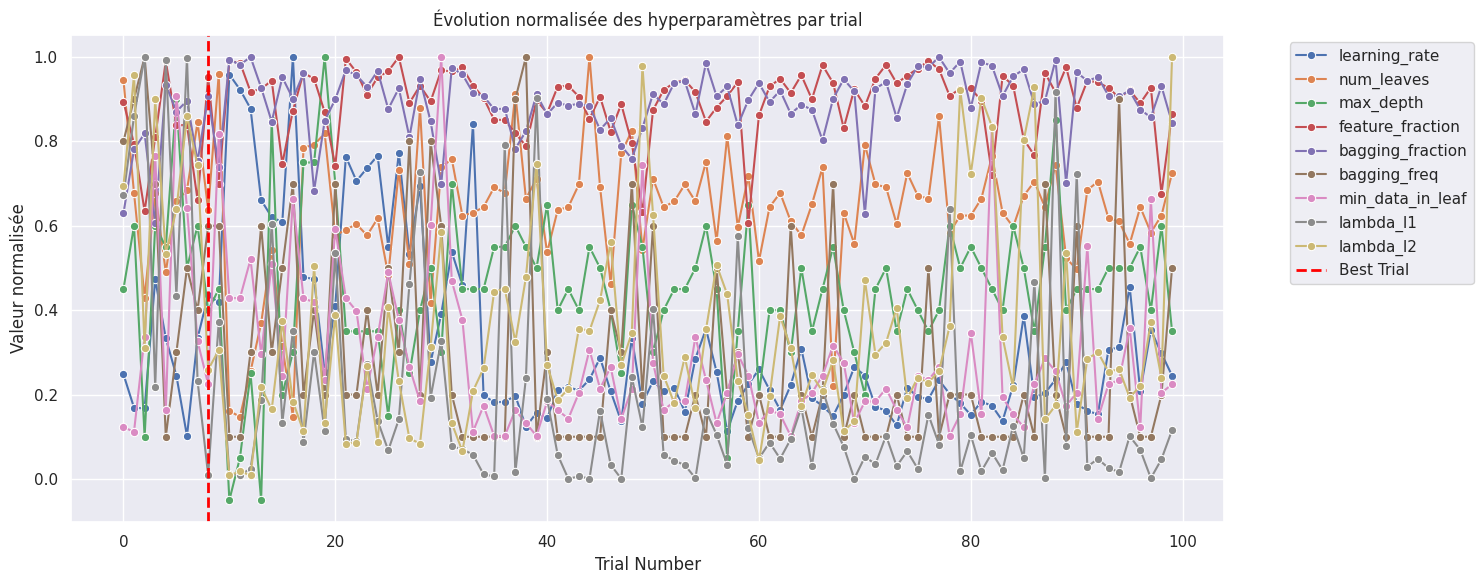

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Liste des colonnes à tracer (sauf score et numéro de trial)
params_to_plot = [col for col in results_df.columns if col not in ["r2_score", "trial_number"]]

# 📌 Création d'une copie pour normalisation
normalized_df = results_df.copy()

# 📌 Normalisation des paramètres : ramène chaque paramètre entre 0 et 1
for col in params_to_plot:
    max_val = normalized_df[col].max()
    if max_val != 0:
        normalized_df[col] = normalized_df[col] / max_val

# 📌 Réorganisation des données au format long
long_df = normalized_df.melt(
    id_vars=["trial_number"],
    value_vars=params_to_plot,
    var_name="hyperparameter",
    value_name="value"
)

# 📌 Récupération du numéro du best trial
best_trial_number = study.best_trial.number

# 📌 Tracer tous les hyperparamètres dans un seul graphique
plt.figure(figsize=(15, 6))
sns.lineplot(data=long_df, x="trial_number", y="value", hue="hyperparameter", marker="o")

# 📌 Marquer le best trial avec une ligne verticale
plt.axvline(x=best_trial_number, color='red', linestyle='--', linewidth=2, label='Best Trial')

plt.title("Évolution normalisée des hyperparamètres par trial")
plt.xlabel("Trial Number")
plt.ylabel("Valeur normalisée")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()